In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import sklearn.preprocessing
import sklearn.model_selection

In [6]:
import uproot
uproot.default_library = "np"

In [7]:
import os.path

In [8]:
import logging
logging.basicConfig(level=logging.INFO)

In [9]:
np.set_printoptions(precision=4, suppress=True)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [11]:
raw_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [12]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [13]:
def true_features(f):
    return [name for name in f.keys() if "TRUE" in name]
def common_features(*fs):
    return sorted(set.intersection(*[set(true_features(f)) for f in fs]))
common_features(*raw_files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Truthing

In [14]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_GeV > %g" % v1, "q2_GeV < %g" % v2)

In [15]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [16]:
features = [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]
features = list(aliases.keys())

In [17]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [18]:
selectors = [
    Kee_selector,
    Je_selector,
    psi2Se_selector,
    Dphipi_ee_selector,
]
selectors = [None]*4

In [19]:
truthed = [f.arrays(true_features(f) + features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [20]:
df_index = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]
df = pd.DataFrame(index=df_index)

In [21]:
df["Total"] = [f["q2"].array(library="np").shape[0] for f in raw_files]
#df["N"] = [b[features[0]].shape[0] for b in truthed]
#df["N/Total"] = df["N"]/df["Total"]
df

Total
B⁺→K⁺ee          970116
B⁺→K⁺J/ψ(→ee)    960234
B⁺→K⁺ψ(2S)(→ee)  986271
D⁺→π⁺φ(→ee)      830027

### KS tests

In [22]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in truthed[0].keys():
        arr0 = truthed[0][feature]
        if not feature in arr:
            continue
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

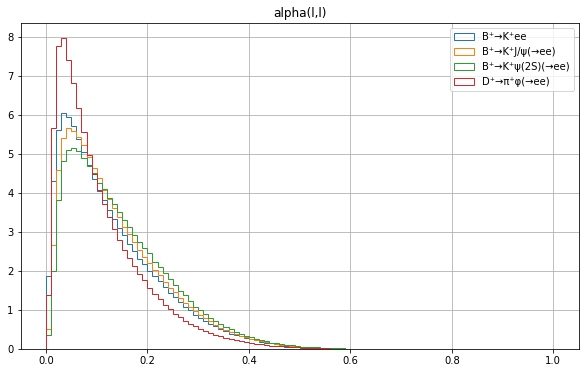

In [23]:
for idx in range(4):
    plt.hist(truthed[idx]['angle_ee_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

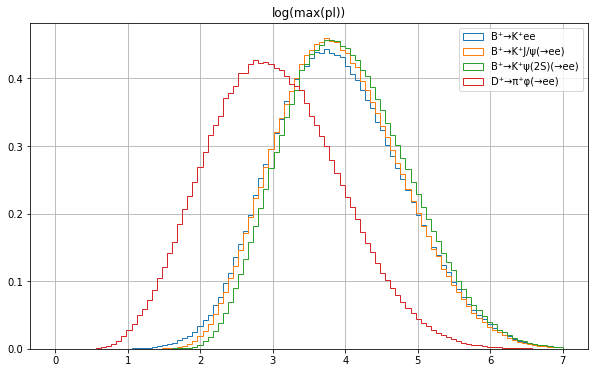

In [24]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 7, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

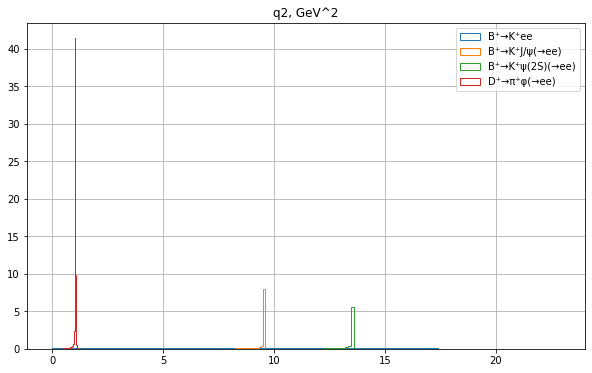

In [25]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2_TRUE'], label="%s"%df_index[idx],
             density=True, bins=100, histtype='step')
plt.title(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

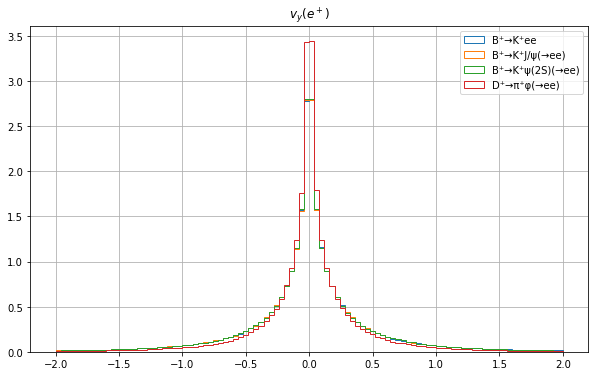

In [26]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['ep_origY_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^+)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [27]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [28]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        try:
            x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        except KeyError:
            x_ = np.ones((len(truthed[ix][list(truthed[ix].keys())[0]]), len(fnames))) * np.nan
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [29]:
class Dataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.scaler.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset

In [30]:
def plot_ds(dataset):
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    #plt.gca().set_aspect('equal')
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(2*ones)[0,0:2]
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.plot()
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [32]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [33]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        total_count = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            count = x.shape[0]
            total_loss += loss
            total_count += count
            if not accumulate:
                loss /= count
                opt.zero_grad()
                loss.backward()
                opt.step()
        total_loss /= total_count
        if accumulate:
            opt.zero_grad()
            total_loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, total_loss)
    model.eval()

### Weight limits estimation

In [34]:
def plot_field(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0):
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(3*ones)[0,0:2]
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.grid()
    #plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [35]:
def plot_clf(ds, clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(ds.scaler.transform(x))))))
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]))

In [36]:
def plot_clf_min_max(ds, clf):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : to_numpy(torch.relu(torch.min(fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.relu(torch.min(-fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min, ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None)
    plot_field(f_max, ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None)

In [37]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = Dataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = self.ds.torch_dataset()
        loader = Loader(dataset, batch_size=10000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=10000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [38]:
e_a4 = Estimator(["alpha"], range(4))
e_a4.train()
e_a3 = Estimator(["alpha"], range(3))
e_a3.train()

INFO:root:Epoch 0, 1.377531
INFO:root:Epoch 1, 1.373174
INFO:root:Epoch 2, 1.372849
INFO:root:Epoch 3, 1.372660
INFO:root:Epoch 4, 1.372486
INFO:root:Epoch 5, 1.372371
INFO:root:Epoch 6, 1.372250
INFO:root:Epoch 7, 1.372196
INFO:root:Epoch 8, 1.372093
INFO:root:Epoch 9, 1.372014
INFO:root:Epoch 10, 1.371945
INFO:root:Epoch 11, 1.371917
INFO:root:Epoch 12, 1.371823
INFO:root:Epoch 13, 1.371774
INFO:root:Epoch 14, 1.371749
INFO:root:Epoch 15, 1.371724
INFO:root:Epoch 16, 1.371673
INFO:root:Epoch 17, 1.371645
INFO:root:Epoch 18, 1.371602
INFO:root:Epoch 19, 1.371589
INFO:root:Epoch 20, 1.371556
INFO:root:Epoch 21, 1.371526
INFO:root:Epoch 22, 1.371507
INFO:root:Epoch 23, 1.371485
INFO:root:Epoch 24, 1.371453
INFO:root:Epoch 25, 1.371430
INFO:root:Epoch 26, 1.371427
INFO:root:Epoch 27, 1.371404
INFO:root:Epoch 28, 1.371368
INFO:root:Epoch 29, 1.371372
INFO:root:Epoch 30, 1.371351
INFO:root:Epoch 31, 1.371349
INFO:root:Epoch 32, 1.371341
INFO:root:Epoch 33, 1.371323
INFO:root:Epoch 34, 1.37

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [39]:
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.133679
INFO:root:Epoch 1, 0.961276
INFO:root:Epoch 2, 0.944066
INFO:root:Epoch 3, 0.937153
INFO:root:Epoch 4, 0.932721
INFO:root:Epoch 5, 0.930108
INFO:root:Epoch 6, 0.928317
INFO:root:Epoch 7, 0.926779
INFO:root:Epoch 8, 0.925466
INFO:root:Epoch 9, 0.924374
INFO:root:Epoch 10, 0.922928
INFO:root:Epoch 11, 0.921314
INFO:root:Epoch 12, 0.919175
INFO:root:Epoch 13, 0.916994
INFO:root:Epoch 14, 0.915435
INFO:root:Epoch 15, 0.914441
INFO:root:Epoch 16, 0.913609
INFO:root:Epoch 17, 0.912953
INFO:root:Epoch 18, 0.912546
INFO:root:Epoch 19, 0.912003
INFO:root:Epoch 20, 0.911659
INFO:root:Epoch 21, 0.911374
INFO:root:Epoch 22, 0.911073
INFO:root:Epoch 23, 0.910873
INFO:root:Epoch 24, 0.910567
INFO:root:Epoch 25, 0.910472
INFO:root:Epoch 26, 0.910309
INFO:root:Epoch 27, 0.910064
INFO:root:Epoch 28, 0.909978
INFO:root:Epoch 29, 0.909923
INFO:root:Epoch 30, 0.909793
INFO:root:Epoch 31, 0.909670
INFO:root:Epoch 32, 0.909502
INFO:root:Epoch 33, 0.909407
INFO:root:Epoch 34, 0.90

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [40]:
e_la3 = Estimator(["alpha", "log_max_pl"], range(3))
e_la3.train()

INFO:root:Epoch 0, 1.082783
INFO:root:Epoch 1, 1.045341
INFO:root:Epoch 2, 1.030071
INFO:root:Epoch 3, 1.025990
INFO:root:Epoch 4, 1.023719
INFO:root:Epoch 5, 1.021505
INFO:root:Epoch 6, 1.018494
INFO:root:Epoch 7, 1.012902
INFO:root:Epoch 8, 1.008154
INFO:root:Epoch 9, 1.005925
INFO:root:Epoch 10, 1.004439
INFO:root:Epoch 11, 1.003191
INFO:root:Epoch 12, 1.002036
INFO:root:Epoch 13, 1.001030
INFO:root:Epoch 14, 1.000120
INFO:root:Epoch 15, 0.999452
INFO:root:Epoch 16, 0.998946
INFO:root:Epoch 17, 0.998489
INFO:root:Epoch 18, 0.998147
INFO:root:Epoch 19, 0.997871
INFO:root:Epoch 20, 0.997636
INFO:root:Epoch 21, 0.997426
INFO:root:Epoch 22, 0.997267
INFO:root:Epoch 23, 0.997083
INFO:root:Epoch 24, 0.996920
INFO:root:Epoch 25, 0.996753
INFO:root:Epoch 26, 0.996653
INFO:root:Epoch 27, 0.996479
INFO:root:Epoch 28, 0.996412
INFO:root:Epoch 29, 0.996303
INFO:root:Epoch 30, 0.996185
INFO:root:Epoch 31, 0.996112
INFO:root:Epoch 32, 0.996034
INFO:root:Epoch 33, 0.996080
INFO:root:Epoch 34, 0.99

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

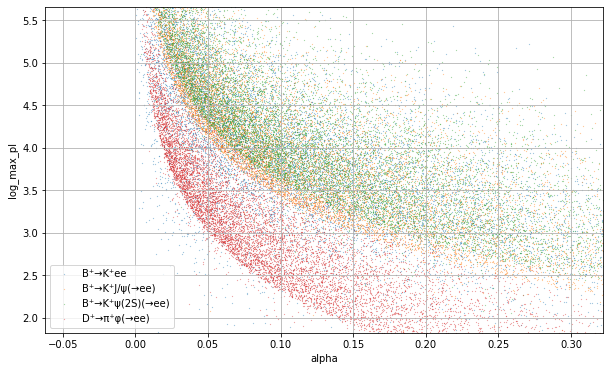

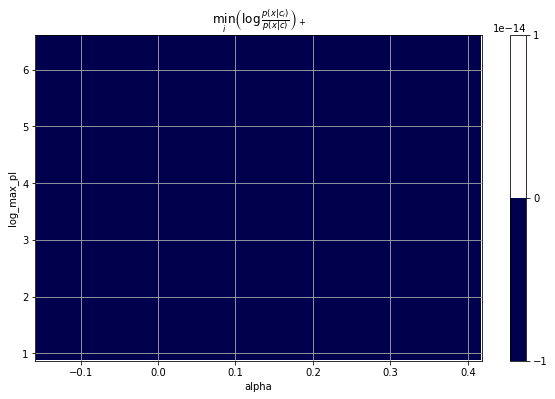

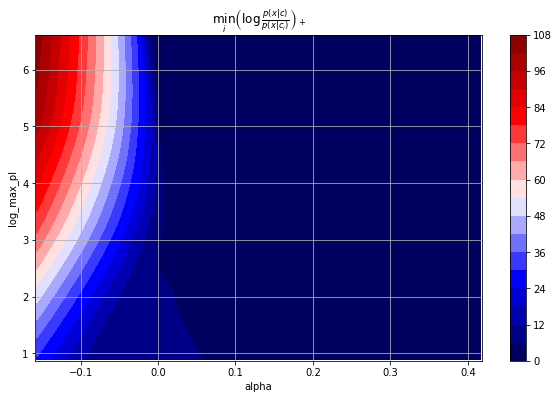

In [41]:
plot_ds(e_la.ds)
plot_clf_min_max(e_la.ds, e_la.model)

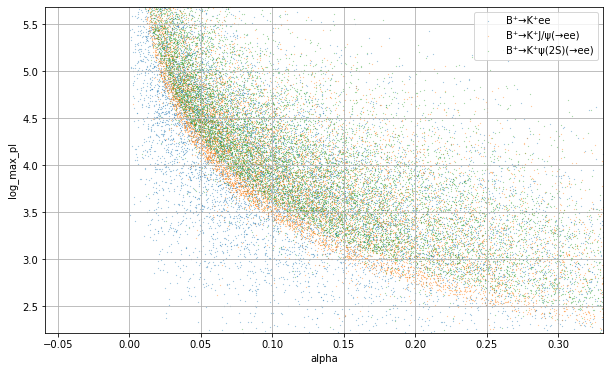

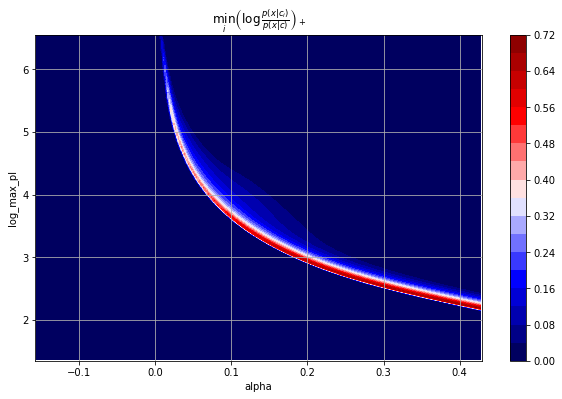

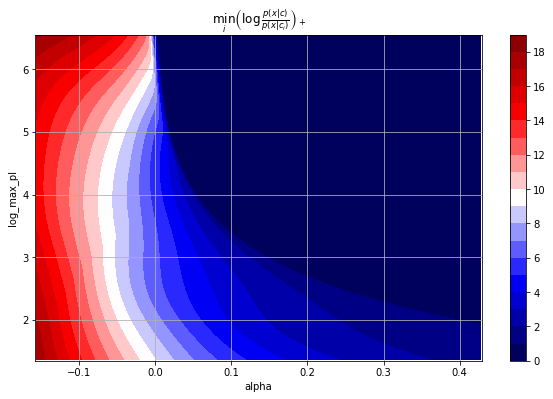

In [42]:
plot_ds(e_la3.ds)
plot_clf_min_max(e_la3.ds, e_la3.model)

In [43]:
e_ptpt = Estimator(["log_ep_PT", "log_em_PT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.152660
INFO:root:Epoch 1, 1.072064
INFO:root:Epoch 2, 1.069413
INFO:root:Epoch 3, 1.067354
INFO:root:Epoch 4, 1.064619
INFO:root:Epoch 5, 1.061801
INFO:root:Epoch 6, 1.059441
INFO:root:Epoch 7, 1.058105
INFO:root:Epoch 8, 1.057425
INFO:root:Epoch 9, 1.057033
INFO:root:Epoch 10, 1.056781
INFO:root:Epoch 11, 1.056559
INFO:root:Epoch 12, 1.056472
INFO:root:Epoch 13, 1.056395
INFO:root:Epoch 14, 1.056215
INFO:root:Epoch 15, 1.056180
INFO:root:Epoch 16, 1.056138
INFO:root:Epoch 17, 1.056132
INFO:root:Epoch 18, 1.056037
INFO:root:Epoch 19, 1.055975
INFO:root:Epoch 20, 1.055932
INFO:root:Epoch 21, 1.055920
INFO:root:Epoch 22, 1.055880
INFO:root:Epoch 23, 1.055805
INFO:root:Epoch 24, 1.055774
INFO:root:Epoch 25, 1.055710
INFO:root:Epoch 26, 1.055730
INFO:root:Epoch 27, 1.055642
INFO:root:Epoch 28, 1.055656
INFO:root:Epoch 29, 1.055641
INFO:root:Epoch 30, 1.055595
INFO:root:Epoch 31, 1.055545
INFO:root:Epoch 32, 1.055611
INFO:root:Epoch 33, 1.055528
INFO:root:Epoch 34, 1.05

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

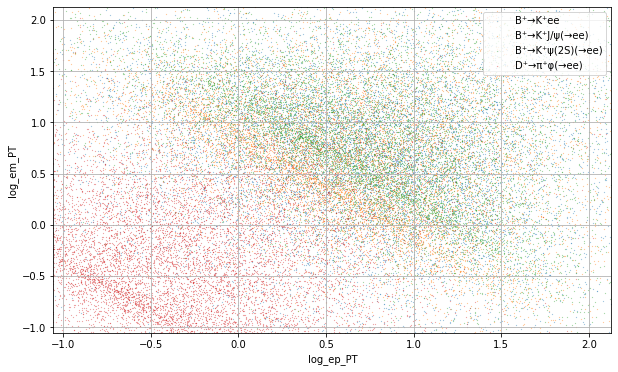

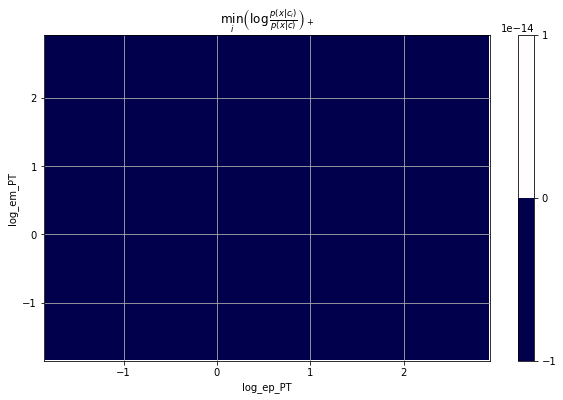

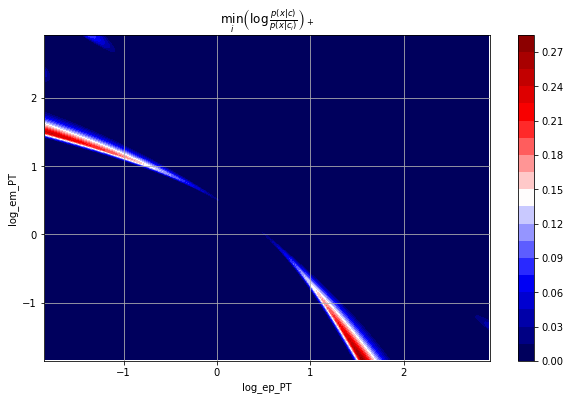

In [44]:
plot_ds(e_ptpt.ds)
plot_clf_min_max(e_ptpt.ds, e_ptpt.model)

In [45]:
e_ptpt3 = Estimator(["log_ep_PT", "log_em_PT"], range(3))
e_ptpt3.train()

INFO:root:Epoch 0, 1.091081
INFO:root:Epoch 1, 1.077758
INFO:root:Epoch 2, 1.073066
INFO:root:Epoch 3, 1.067629
INFO:root:Epoch 4, 1.063974
INFO:root:Epoch 5, 1.062857
INFO:root:Epoch 6, 1.062451
INFO:root:Epoch 7, 1.062138
INFO:root:Epoch 8, 1.062074
INFO:root:Epoch 9, 1.061974
INFO:root:Epoch 10, 1.061888
INFO:root:Epoch 11, 1.061914
INFO:root:Epoch 12, 1.061863
INFO:root:Epoch 13, 1.061790
INFO:root:Epoch 14, 1.061742
INFO:root:Epoch 15, 1.061725
INFO:root:Epoch 16, 1.061672
INFO:root:Epoch 17, 1.061644
INFO:root:Epoch 18, 1.061610
INFO:root:Epoch 19, 1.061566
INFO:root:Epoch 20, 1.061504
INFO:root:Epoch 21, 1.061529
INFO:root:Epoch 22, 1.061404
INFO:root:Epoch 23, 1.061408
INFO:root:Epoch 24, 1.061367
INFO:root:Epoch 25, 1.061383
INFO:root:Epoch 26, 1.061336
INFO:root:Epoch 27, 1.061283
INFO:root:Epoch 28, 1.061228
INFO:root:Epoch 29, 1.061201
INFO:root:Epoch 30, 1.061155
INFO:root:Epoch 31, 1.061122
INFO:root:Epoch 32, 1.061071
INFO:root:Epoch 33, 1.061030
INFO:root:Epoch 34, 1.06

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

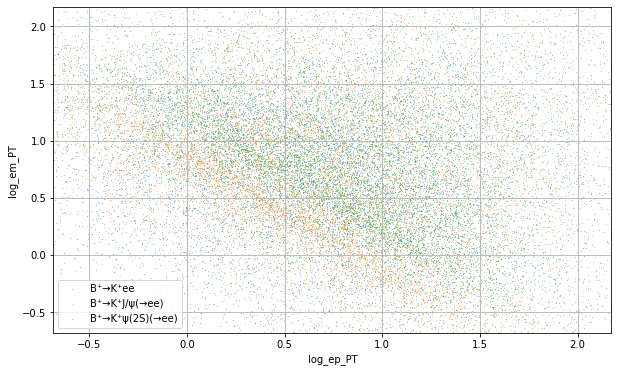

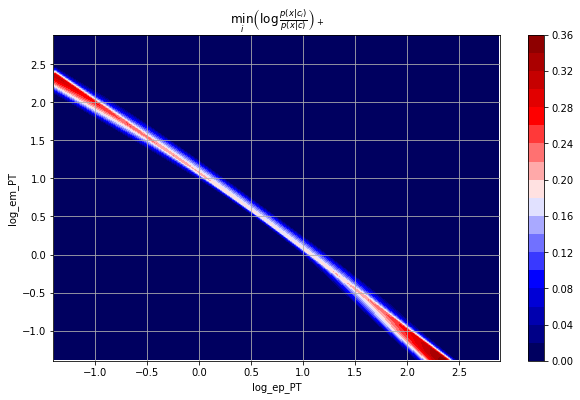

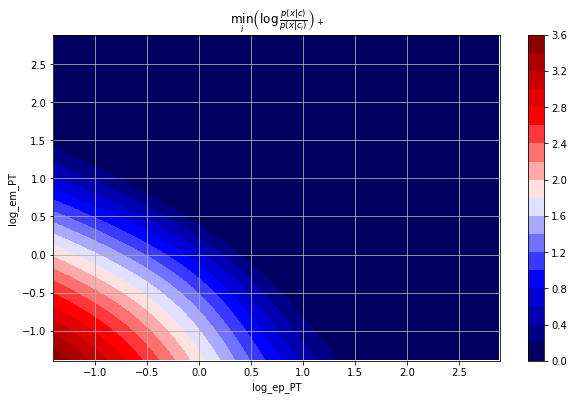

In [46]:
plot_ds(e_ptpt3.ds)
plot_clf_min_max(e_ptpt3.ds, e_ptpt3.model)

### Crafting a loss

In [47]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec, 0)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [48]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W

In [49]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        W = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        #print(pred.shape, W.shape, W_pinv.shape)
        #print(W_pinv, w1j, wki, W_m)
        #print(ratio_estimator(w1j))
        #loss = torch.sum(W*from_numpy(W_m_))
        loss_c = torch.sum(W*from_numpy(W_m_))
        loss_d = -torch.sum(W*(W_pinv_.T))
        loss = loss_d + alpha * loss_c
        opt.zero_grad()
        loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det)
        #raise NotImplementedError
    model.eval()

In [50]:
@torch.no_grad()
def make_weighting(model, loader, selected_class, n_outs, n_classes):
    W = to_numpy(create_w(model, loader, n_outs, n_classes))
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=1), linear)

In [51]:
class Weighting():
    def __init__(self, estimator):
        N = len(list(estimator.ds.indices))
        self.estimator = estimator
        self.model = model(len(estimator.ds.features), N).to(device)
        self.model.load_state_dict(estimator.model.state_dict())
        self.n_outs = N
        self.n_classes = N
    def train(self):
        self.w_model_ = None
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=500, alpha=300)
        return self.w_model()
    def w_model(self):
        if self.w_model_ is None:
            loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
            self.w_model_ = make_weighting(self.model, loader, 0, self.n_outs, self.n_classes)
        return self.w_model_
    def w_model_np(self):
        fn = self.w_model()
        fn_np = lambda x : to_numpy(fn(from_numpy(self.estimator.ds.scaler.transform(x))))
        return fn_np
    def dataset(self):
        return self.estimator.ds

In [52]:
w_la = Weighting(e_la)
w_la.train()

Epoch 0, loss=-4.000052 est=0.129099 [19.4207 -7.5799 -7.746  -3.046 ] 0.0017613058
Epoch 1, loss=-4.000056 est=0.140313 [17.996  -7.1269 -5.7064 -3.4003] 0.0021090093
Epoch 2, loss=-4.000059 est=0.150785 [17.0709 -6.6319 -4.3483 -3.7237] 0.0024522268
Epoch 3, loss=-4.000061 est=0.163570 [16.4716 -6.1136 -3.4137 -3.9127] 0.002809153
Epoch 4, loss=-4.000063 est=0.178814 [16.0587 -5.5924 -2.7418 -3.966 ] 0.003188014
Epoch 5, loss=-4.000063 est=0.196017 [15.7376 -5.1016 -2.2304 -3.9291] 0.0035841046
Epoch 6, loss=-4.000065 est=0.214362 [15.4437 -4.665  -1.8209 -3.85  ] 0.0039890492
Epoch 7, loss=-4.000066 est=0.233089 [15.1379 -4.2902 -1.4828 -3.7626] 0.0043963897
Epoch 8, loss=-4.000067 est=0.251547 [14.7964 -3.9754 -1.1989 -3.6864] 0.0048026624
Epoch 9, loss=-4.000070 est=0.269200 [14.4087 -3.7147 -0.9583 -3.6305] 0.005206539
Epoch 10, loss=-4.000072 est=0.278050 [13.9779 -3.501  -0.7541 -3.5965] 0.005606909
Epoch 11, loss=-4.000074 est=0.279146 [13.5186 -3.3263 -0.5816 -3.5824] 0.00600

Epoch 98, loss=-4.000084 est=0.343888 [ 7.9265 -0.9288  0.0836 -2.9079] 0.015516589
Epoch 99, loss=-4.000084 est=0.344201 [ 7.9202 -0.9262  0.0833 -2.9053] 0.015537551
Epoch 100, loss=-4.000084 est=0.344513 [ 7.9137 -0.9238  0.083  -2.9026] 0.015558182
Epoch 101, loss=-4.000084 est=0.344824 [ 7.9071 -0.9217  0.0828 -2.9   ] 0.015578483
Epoch 102, loss=-4.000084 est=0.345133 [ 7.9006 -0.9197  0.0826 -2.8974] 0.01559842
Epoch 103, loss=-4.000084 est=0.345440 [ 7.8944 -0.9175  0.0823 -2.8949] 0.015618064
Epoch 104, loss=-4.000084 est=0.345745 [ 7.8886 -0.9153  0.082  -2.8923] 0.015637403
Epoch 105, loss=-4.000084 est=0.346049 [ 7.8833 -0.9128  0.0817 -2.8898] 0.015656415
Epoch 106, loss=-4.000084 est=0.346352 [ 7.8783 -0.9102  0.0814 -2.8872] 0.015675148
Epoch 107, loss=-4.000084 est=0.346659 [ 7.8734 -0.9077  0.081  -2.8847] 0.015693592
Epoch 108, loss=-4.000084 est=0.346971 [ 7.8686 -0.9054  0.0807 -2.8821] 0.015711715
Epoch 109, loss=-4.000084 est=0.347289 [ 7.8637 -0.9032  0.0804 -2.8

Epoch 195, loss=-4.000082 est=0.365615 [ 7.6519 -0.7958  0.0627 -2.7351] 0.0166165
Epoch 196, loss=-4.000082 est=0.365734 [ 7.6506 -0.7951  0.0626 -2.7342] 0.016622283
Epoch 197, loss=-4.000082 est=0.365852 [ 7.6494 -0.7943  0.0624 -2.7333] 0.016627999
Epoch 198, loss=-4.000082 est=0.365970 [ 7.6481 -0.7936  0.0623 -2.7325] 0.016633658
Epoch 199, loss=-4.000082 est=0.366088 [ 7.6469 -0.7929  0.0621 -2.7316] 0.016639316
Epoch 0, loss=-28.564194 est=0.366205 [ 7.6457 -0.7922  0.062  -2.7307] 0.016644903
Epoch 1, loss=-25.534853 est=0.373977 [ 8.2598 -0.5839  0.0288 -2.674 ] 0.016234823
Epoch 2, loss=-23.504831 est=0.393069 [ 8.7787 -0.5352  0.0249 -2.5441] 0.015757827
Epoch 3, loss=-21.863171 est=0.420952 [ 9.2233 -0.5235  0.0285 -2.3756] 0.015379745
Epoch 4, loss=-20.422733 est=0.455607 [ 9.6385 -0.5265  0.0356 -2.1949] 0.015036158
Epoch 5, loss=-19.107969 est=0.495901 [10.0612 -0.5378  0.0452 -2.0165] 0.014670949
Epoch 6, loss=-17.878866 est=0.540959 [10.5258 -0.5545  0.057  -1.8486] 0

Epoch 92, loss=-4.400815 est=4.245727 [56.1233 -0.0105 -0.0022 -0.2355] 0.003177674
Epoch 93, loss=-4.400134 est=4.232899 [56.0442 -0.0104 -0.0022 -0.2362] 0.0031850573
Epoch 94, loss=-4.398526 est=4.227946 [56.0033 -0.0104 -0.0022 -0.2365] 0.0031902469
Epoch 95, loss=-4.396187 est=4.229312 [55.9934 -0.0103 -0.0022 -0.2364] 0.003193622
Epoch 96, loss=-4.393373 est=4.235005 [56.0048 -0.0103 -0.0022 -0.2361] 0.0031956949
Epoch 97, loss=-4.390353 est=4.242873 [56.0273 -0.0103 -0.0022 -0.2357] 0.0031970167
Epoch 98, loss=-4.387381 est=4.250872 [56.0508 -0.0102 -0.0023 -0.2352] 0.003198143
Epoch 99, loss=-4.384666 est=4.257220 [56.0664 -0.0102 -0.0023 -0.2349] 0.0031995592
Epoch 100, loss=-4.382367 est=4.260566 [56.0671 -0.0102 -0.0023 -0.2347] 0.0032016567
Epoch 101, loss=-4.380583 est=4.260011 [56.0482 -0.0101 -0.0023 -0.2347] 0.0032046959
Epoch 102, loss=-4.379354 est=4.255180 [56.0079 -0.01   -0.0023 -0.235 ] 0.0032087902
Epoch 103, loss=-4.378664 est=4.246175 [55.9467 -0.01   -0.0023 -

Epoch 188, loss=-4.359029 est=4.131729 [54.3195 -0.0054 -0.0026 -0.242 ] 0.003326824
Epoch 189, loss=-4.358982 est=4.132159 [54.3127 -0.0054 -0.0026 -0.242 ] 0.0033272197
Epoch 190, loss=-4.358931 est=4.132604 [54.3061 -0.0054 -0.0026 -0.242 ] 0.0033276076
Epoch 191, loss=-4.358875 est=4.133107 [54.2997 -0.0053 -0.0026 -0.2419] 0.0033279832
Epoch 192, loss=-4.358813 est=4.133681 [54.2937 -0.0053 -0.0026 -0.2419] 0.0033283394
Epoch 193, loss=-4.358741 est=4.134340 [54.2882 -0.0053 -0.0026 -0.2419] 0.0033286705
Epoch 194, loss=-4.358663 est=4.135064 [54.283  -0.0053 -0.0026 -0.2418] 0.0033289802
Epoch 195, loss=-4.358581 est=4.135837 [54.278  -0.0052 -0.0026 -0.2418] 0.0033292829
Epoch 196, loss=-4.358497 est=4.136636 [54.2732 -0.0052 -0.0026 -0.2417] 0.00332958
Epoch 197, loss=-4.358416 est=4.137421 [54.2684 -0.0052 -0.0026 -0.2417] 0.003329869
Epoch 198, loss=-4.358339 est=4.138178 [54.2634 -0.0052 -0.0026 -0.2417] 0.0033301734
Epoch 199, loss=-4.358270 est=4.138886 [54.2583 -0.0052 -0

Epoch 284, loss=-4.354103 est=4.204013 [53.9133 -0.0045 -0.0026 -0.2379] 0.0033537191
Epoch 285, loss=-4.354064 est=4.204710 [53.9095 -0.0045 -0.0026 -0.2378] 0.0033539834
Epoch 286, loss=-4.354026 est=4.205408 [53.9056 -0.0045 -0.0026 -0.2378] 0.0033542525
Epoch 287, loss=-4.353987 est=4.206106 [53.9018 -0.0045 -0.0026 -0.2377] 0.0033545177
Epoch 288, loss=-4.353949 est=4.206802 [53.898  -0.0045 -0.0026 -0.2377] 0.0033547808
Epoch 289, loss=-4.353910 est=4.207499 [53.8941 -0.0045 -0.0026 -0.2377] 0.0033550495
Epoch 290, loss=-4.353872 est=4.208198 [53.8903 -0.0045 -0.0026 -0.2376] 0.003355311
Epoch 291, loss=-4.353835 est=4.208888 [53.8864 -0.0045 -0.0026 -0.2376] 0.0033555792
Epoch 292, loss=-4.353796 est=4.209579 [53.8826 -0.0045 -0.0026 -0.2376] 0.0033558432
Epoch 293, loss=-4.353759 est=4.210264 [53.8788 -0.0045 -0.0026 -0.2375] 0.003356103
Epoch 294, loss=-4.353723 est=4.210940 [53.8749 -0.0045 -0.0026 -0.2375] 0.003356376
Epoch 295, loss=-4.353688 est=4.211606 [53.871  -0.0045 -

Epoch 380, loss=-4.351125 est=4.263461 [53.545  -0.0044 -0.0026 -0.2346] 0.0033793345
Epoch 381, loss=-4.351099 est=4.264013 [53.5412 -0.0044 -0.0026 -0.2345] 0.0033795997
Epoch 382, loss=-4.351074 est=4.264566 [53.5374 -0.0044 -0.0026 -0.2345] 0.0033798676
Epoch 383, loss=-4.351050 est=4.265107 [53.5336 -0.0044 -0.0026 -0.2345] 0.003380139
Epoch 384, loss=-4.351026 est=4.265646 [53.5298 -0.0044 -0.0026 -0.2344] 0.003380405
Epoch 385, loss=-4.351001 est=4.266192 [53.526  -0.0044 -0.0026 -0.2344] 0.0033806732
Epoch 386, loss=-4.350976 est=4.266745 [53.5223 -0.0044 -0.0026 -0.2344] 0.0033809382
Epoch 387, loss=-4.350951 est=4.267298 [53.5185 -0.0044 -0.0026 -0.2343] 0.0033812004
Epoch 388, loss=-4.350925 est=4.267842 [53.5148 -0.0044 -0.0026 -0.2343] 0.0033814597
Epoch 389, loss=-4.350901 est=4.268391 [53.511  -0.0044 -0.0026 -0.2343] 0.003381726
Epoch 390, loss=-4.350875 est=4.268937 [53.5072 -0.0044 -0.0026 -0.2343] 0.0033819894
Epoch 391, loss=-4.350852 est=4.269470 [53.5035 -0.0044 -

Epoch 476, loss=-4.349024 est=4.311547 [53.1922 -0.0044 -0.0026 -0.2319] 0.0034044727
Epoch 477, loss=-4.349006 est=4.311994 [53.1886 -0.0044 -0.0026 -0.2319] 0.0034047305
Epoch 478, loss=-4.348986 est=4.312449 [53.1851 -0.0044 -0.0026 -0.2319] 0.0034049905
Epoch 479, loss=-4.348967 est=4.312907 [53.1816 -0.0044 -0.0026 -0.2319] 0.0034052455
Epoch 480, loss=-4.348947 est=4.313365 [53.178  -0.0044 -0.0026 -0.2318] 0.0034054965
Epoch 481, loss=-4.348928 est=4.313811 [53.1745 -0.0044 -0.0026 -0.2318] 0.0034057512
Epoch 482, loss=-4.348908 est=4.314264 [53.171  -0.0044 -0.0026 -0.2318] 0.0034060057
Epoch 483, loss=-4.348890 est=4.314710 [53.1674 -0.0045 -0.0026 -0.2318] 0.003406265
Epoch 484, loss=-4.348873 est=4.315144 [53.1639 -0.0045 -0.0026 -0.2317] 0.0034065181
Epoch 485, loss=-4.348855 est=4.315585 [53.1603 -0.0045 -0.0026 -0.2317] 0.003406782
Epoch 486, loss=-4.348836 est=4.316026 [53.1568 -0.0045 -0.0026 -0.2317] 0.0034070362
Epoch 487, loss=-4.348817 est=4.316472 [53.1533 -0.0045 

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [53]:
w_la3 = Weighting(e_la3)
w_la3.train()

Epoch 0, loss=-3.000184 est=0.371986 [ 5.4327 -2.6883 -1.7304] 0.00881002
Epoch 1, loss=-3.000196 est=0.347910 [ 5.0759 -2.8743 -1.2763] 0.009668635
Epoch 2, loss=-3.000201 est=0.359290 [ 4.9698 -2.7833 -1.1998] 0.010392477
Epoch 3, loss=-3.000202 est=0.391838 [ 4.9498 -2.5521 -1.2777] 0.011146113
Epoch 4, loss=-3.000202 est=0.439997 [ 4.9728 -2.2727 -1.4078] 0.011920555
Epoch 5, loss=-3.000199 est=0.498836 [ 5.0169 -2.0047 -1.5312] 0.012680152
Epoch 6, loss=-3.000197 est=0.562945 [ 5.0638 -1.7764 -1.6181] 0.013409135
Epoch 7, loss=-3.000196 est=0.602956 [ 5.0976 -1.5946 -1.6585] 0.014119062
Epoch 8, loss=-3.000189 est=0.604040 [ 5.1096 -1.4547 -1.6555] 0.014828365
Epoch 9, loss=-3.000183 est=0.617951 [ 5.0995 -1.3488 -1.6183] 0.015544875
Epoch 10, loss=-3.000176 est=0.642192 [ 5.0726 -1.2694 -1.5572] 0.016264874
Epoch 11, loss=-3.000171 est=0.674713 [ 5.0369 -1.2092 -1.4821] 0.016980117
Epoch 12, loss=-3.000165 est=0.713558 [ 4.9995 -1.1609 -1.4014] 0.017685192
Epoch 13, loss=-3.00015

Epoch 109, loss=-3.000020 est=2.115591 [ 4.7757 -0.4727  0.0064] 0.038755484
Epoch 110, loss=-3.000020 est=2.118457 [ 4.7752 -0.472   0.0064] 0.038768776
Epoch 111, loss=-3.000020 est=2.120903 [ 4.7746 -0.4715  0.0065] 0.03878186
Epoch 112, loss=-3.000021 est=2.122890 [ 4.7738 -0.4711  0.0065] 0.038794663
Epoch 113, loss=-3.000020 est=2.124599 [ 4.773  -0.4707  0.0066] 0.038807314
Epoch 114, loss=-3.000020 est=2.126298 [ 4.7723 -0.4703  0.0067] 0.038819704
Epoch 115, loss=-3.000020 est=2.128254 [ 4.7715 -0.4699  0.0067] 0.038831893
Epoch 116, loss=-3.000020 est=2.130577 [ 4.7709 -0.4694  0.0068] 0.03884391
Epoch 117, loss=-3.000020 est=2.133199 [ 4.7704 -0.4688  0.0068] 0.038855717
Epoch 118, loss=-3.000020 est=2.135909 [ 4.7699 -0.4682  0.0068] 0.038867347
Epoch 119, loss=-3.000020 est=2.138454 [ 4.7694 -0.4676  0.0069] 0.03887876
Epoch 120, loss=-3.000020 est=2.140669 [ 4.7688 -0.4671  0.0069] 0.03889002
Epoch 121, loss=-3.000020 est=2.142526 [ 4.7681 -0.4667  0.0069] 0.03890115
Epoc

Epoch 17, loss=-4.501577 est=6.947755 [ 7.8539 -0.1439 -0.0103] 0.025397394
Epoch 18, loss=-4.388918 est=7.312628 [ 8.1518 -0.1367 -0.0096] 0.024473175
Epoch 19, loss=-4.279447 est=7.705826 [ 8.4852 -0.1298 -0.0089] 0.023511805
Epoch 20, loss=-4.175957 est=8.118914 [ 8.8512 -0.1232 -0.0083] 0.022535779
Epoch 21, loss=-4.081244 est=8.539849 [ 9.241  -0.1171 -0.0076] 0.021577336
Epoch 22, loss=-3.997667 est=8.954898 [ 9.6389 -0.1117 -0.007 ] 0.020674933
Epoch 23, loss=-3.926796 est=9.350764 [10.023  -0.1069 -0.0064] 0.019866938
Epoch 24, loss=-3.869411 est=9.714704 [10.3686 -0.1029 -0.0059] 0.019185608
Epoch 25, loss=-3.825653 est=10.034460 [10.6515 -0.0997 -0.0054] 0.018653288
Epoch 26, loss=-3.795150 est=10.299165 [10.8532 -0.0971 -0.005 ] 0.018281005
Epoch 27, loss=-3.777116 est=10.501328 [10.9631 -0.0952 -0.0046] 0.018068992
Epoch 28, loss=-3.770524 est=10.637882 [10.9807 -0.094  -0.0042] 0.018008608
Epoch 29, loss=-3.774189 est=10.710466 [10.914  -0.0934 -0.0038] 0.01808472
Epoch 30

Epoch 124, loss=-3.671492 est=11.808222 [ 9.0245 -0.0847  0.0008] 0.021594182
Epoch 125, loss=-3.671540 est=11.807524 [ 9.0225 -0.0847  0.0008] 0.021604935
Epoch 126, loss=-3.671409 est=11.808720 [ 9.0215 -0.0847  0.0008] 0.021613246
Epoch 127, loss=-3.671098 est=11.811846 [ 9.0216 -0.0847  0.0007] 0.02161911
Epoch 128, loss=-3.670604 est=11.816871 [ 9.0226 -0.0846  0.0007] 0.021622598
Epoch 129, loss=-3.669975 est=11.823367 [ 9.0245 -0.0846  0.0007] 0.021624072
Epoch 130, loss=-3.669229 est=11.831138 [ 9.027  -0.0845  0.0006] 0.021623928
Epoch 131, loss=-3.668398 est=11.839821 [ 9.03   -0.0845  0.0006] 0.021622611
Epoch 132, loss=-3.667521 est=11.848986 [ 9.0332 -0.0844  0.0006] 0.021620551
Epoch 133, loss=-3.666637 est=11.858265 [ 9.0366 -0.0843  0.0006] 0.02161829
Epoch 134, loss=-3.665779 est=11.867291 [ 9.0398 -0.0843  0.0005] 0.021616278
Epoch 135, loss=-3.664975 est=11.875724 [ 9.0427 -0.0842  0.0005] 0.021614883
Epoch 136, loss=-3.664252 est=11.883329 [ 9.0451 -0.0842  0.0005] 

Epoch 230, loss=-3.669222 est=11.972062 [ 8.9173 -0.0835  0.0004] 0.022029387
Epoch 231, loss=-3.659434 est=12.074978 [ 8.9698 -0.0828  0.0003] 0.021915149
Epoch 232, loss=-3.649746 est=12.178831 [ 9.0232 -0.0821  0.0001] 0.021799613
Epoch 233, loss=-3.640790 est=12.276503 [ 9.0736 -0.0815  0.    ] 0.021691678
Epoch 234, loss=-3.813130 est=12.361566 [ 9.1178 -0.0809 -0.0001] 0.021598596
Epoch 235, loss=-3.796912 est=12.514856 [ 9.193  -0.0799 -0.0001] 0.021429932
Epoch 236, loss=-3.776378 est=12.723314 [ 9.2927 -0.0786 -0.0002] 0.021203794
Epoch 237, loss=-3.753375 est=12.972609 [ 9.4101 -0.0771 -0.0002] 0.020939387
Epoch 238, loss=-3.729713 est=13.246579 [ 9.5373 -0.0755 -0.0001] 0.020656435
Epoch 239, loss=-3.707040 est=13.527438 [ 9.6658 -0.0739 -0.0001] 0.020374445
Epoch 240, loss=-3.686770 est=13.796417 [ 9.7867 -0.0725 -0.    ] 0.020111784
Epoch 241, loss=-3.517258 est=14.034344 [ 9.8916 -0.0713  0.0001] 0.019884443
Epoch 242, loss=-3.512939 est=14.120381 [ 9.9242 -0.0708  0.0002

Epoch 336, loss=-3.658731 est=12.224549 [ 8.9091 -0.0818  0.0007] 0.022071078
Epoch 337, loss=-3.653958 est=12.271959 [ 8.9343 -0.0815  0.0005] 0.022026366
Epoch 338, loss=-3.648283 est=12.329262 [ 8.9654 -0.0811  0.0004] 0.021967418
Epoch 339, loss=-3.642337 est=12.389994 [ 8.999  -0.0807  0.0002] 0.02190246
Epoch 340, loss=-3.636608 est=12.448887 [ 9.032  -0.0803  0.0001] 0.021838505
Epoch 341, loss=-3.810769 est=12.501521 [ 9.0618 -0.08   -0.    ] 0.021781275
Epoch 342, loss=-3.797732 est=12.624016 [ 9.1214 -0.0792 -0.0001] 0.021647718
Epoch 343, loss=-3.780152 est=12.804767 [ 9.2053 -0.0781 -0.0001] 0.021453867
Epoch 344, loss=-3.759632 est=13.031414 [ 9.3076 -0.0767 -0.0001] 0.021216292
Epoch 345, loss=-3.737689 est=13.290989 [ 9.4222 -0.0752 -0.0001] 0.020951819
Epoch 346, loss=-3.554559 est=13.568925 [ 9.5424 -0.0737  0.    ] 0.02067686
Epoch 347, loss=-3.543063 est=13.758132 [ 9.621  -0.0727  0.0001] 0.02049644
Epoch 348, loss=-3.538018 est=13.850084 [ 9.6549 -0.0722  0.0002] 0

Epoch 442, loss=-3.792782 est=12.762629 [ 9.0876 -0.0784 -0.0001] 0.021779554
Epoch 443, loss=-3.780844 est=12.880721 [ 9.142  -0.0776 -0.0002] 0.021657681
Epoch 444, loss=-3.764118 est=13.063844 [ 9.2216 -0.0765 -0.0002] 0.02147215
Epoch 445, loss=-3.744007 est=13.301316 [ 9.3217 -0.0752 -0.0001] 0.021237558
Epoch 446, loss=-3.721902 est=13.581425 [ 9.437  -0.0736 -0.0001] 0.020968704
Epoch 447, loss=-3.541959 est=13.890333 [ 9.5618 -0.072   0.    ] 0.020680783
Epoch 448, loss=-3.529623 est=14.107511 [ 9.6465 -0.0709  0.0001] 0.020485163
Epoch 449, loss=-3.523892 est=14.218317 [ 9.6858 -0.0703  0.0002] 0.020387812
Epoch 450, loss=-3.524515 est=14.220631 [ 9.6796 -0.0703  0.0004] 0.020386748
Epoch 451, loss=-3.530849 est=14.124994 [ 9.6332 -0.0708  0.0005] 0.0204715
Epoch 452, loss=-3.541835 est=13.953014 [ 9.556  -0.0717  0.0006] 0.02062427
Epoch 453, loss=-3.556105 est=13.732658 [ 9.4599 -0.0728  0.0007] 0.020822883
Epoch 454, loss=-3.572065 est=13.493428 [ 9.357  -0.0741  0.0008] 0.

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [54]:
w_ptpt = Weighting(e_ptpt)
w_ptpt.train()

Epoch 0, loss=-4.000014 est=0.031033 [ 68.8701 -30.2297 -32.2239  -5.5043] 0.00025167537
Epoch 1, loss=-4.000016 est=0.034753 [ 61.1957 -27.1715 -28.7742  -6.269 ] 0.00029215467
Epoch 2, loss=-4.000018 est=0.038448 [ 55.067  -24.7058 -26.0089  -7.1286] 0.00033287168
Epoch 3, loss=-4.000019 est=0.041892 [ 50.2753 -22.7741 -23.8709  -7.8825] 0.00037330296
Epoch 4, loss=-4.000021 est=0.044904 [ 46.5825 -21.2756 -22.2698  -8.3652] 0.00041393223
Epoch 5, loss=-4.000024 est=0.047452 [ 43.7031 -20.0803 -21.0741  -8.5739] 0.0004552793
Epoch 6, loss=-4.000023 est=0.049573 [ 41.4223 -19.1006 -20.1723  -8.5489] 0.00049765484
Epoch 7, loss=-4.000024 est=0.051340 [ 39.5802 -18.2768 -19.4781  -8.344 ] 0.0005412269
Epoch 8, loss=-4.000026 est=0.052844 [ 38.0524 -17.5677 -18.9236  -8.0183] 0.00058601046
Epoch 9, loss=-4.000027 est=0.054187 [ 36.7387 -16.9429 -18.4546  -7.6271] 0.000631934
Epoch 10, loss=-4.000027 est=0.055463 [ 35.5605 -16.3797 -18.0299  -7.217 ] 0.0006789145
Epoch 11, loss=-4.000029 

Epoch 93, loss=-4.000070 est=0.070249 [  8.605   -1.8856 -14.235    0.4768] 0.0054672346
Epoch 94, loss=-4.000070 est=0.070411 [  8.5789  -1.8885 -14.2023   0.4782] 0.005496437
Epoch 95, loss=-4.000071 est=0.070568 [  8.5543  -1.8928 -14.1706   0.4796] 0.005524825
Epoch 96, loss=-4.000071 est=0.070721 [  8.5312  -1.8987 -14.14     0.4808] 0.0055524064
Epoch 97, loss=-4.000071 est=0.070870 [  8.5094  -1.9057 -14.1103   0.4819] 0.005579257
Epoch 98, loss=-4.000071 est=0.071015 [  8.4889  -1.914  -14.0816   0.4829] 0.005605365
Epoch 99, loss=-4.000071 est=0.071155 [  8.4695  -1.9234 -14.0538   0.4839] 0.0056307865
Epoch 100, loss=-4.000071 est=0.071291 [  8.4512  -1.9337 -14.027    0.4848] 0.005655494
Epoch 101, loss=-4.000072 est=0.071424 [  8.4339  -1.9448 -14.0009   0.4856] 0.0056795673
Epoch 102, loss=-4.000071 est=0.071552 [  8.4176  -1.9567 -13.9758   0.4864] 0.0057029575
Epoch 103, loss=-4.000072 est=0.071677 [  8.4021  -1.9693 -13.9514   0.4871] 0.0057257744
Epoch 104, loss=-4.000

Epoch 185, loss=-4.000076 est=0.076392 [  7.847   -2.6056 -13.0904   0.4887] 0.0065851305
Epoch 186, loss=-4.000076 est=0.076415 [  7.8433  -2.6084 -13.0864   0.4886] 0.0065897764
Epoch 187, loss=-4.000077 est=0.076438 [  7.8397  -2.6112 -13.0825   0.4884] 0.0065943412
Epoch 188, loss=-4.000076 est=0.076460 [  7.8362  -2.6139 -13.0787   0.4883] 0.0065988195
Epoch 189, loss=-4.000077 est=0.076482 [  7.8326  -2.6165 -13.0749   0.4881] 0.006603294
Epoch 190, loss=-4.000076 est=0.076504 [  7.8291  -2.6191 -13.0713   0.488 ] 0.0066076475
Epoch 191, loss=-4.000076 est=0.076525 [  7.8257  -2.6216 -13.0676   0.4878] 0.006611969
Epoch 192, loss=-4.000077 est=0.076546 [  7.8223  -2.624  -13.064    0.4877] 0.0066162194
Epoch 193, loss=-4.000077 est=0.076567 [  7.8189  -2.6264 -13.0605   0.4875] 0.006620416
Epoch 194, loss=-4.000076 est=0.076587 [  7.8156  -2.6288 -13.0571   0.4874] 0.0066245375
Epoch 195, loss=-4.000076 est=0.076607 [  7.8122  -2.6311 -13.0537   0.4872] 0.0066286107
Epoch 196, lo

Epoch 80, loss=-20.768066 est=0.188142 [ 3.6938 17.8912 -5.3151 -1.6508] 0.0027935447
Epoch 81, loss=-20.684572 est=0.188246 [ 3.6863 17.9807 -5.3122 -1.6488] 0.0027854024
Epoch 82, loss=-20.602097 est=0.188330 [ 3.6787 18.07   -5.3098 -1.6465] 0.002777537
Epoch 83, loss=-20.521664 est=0.188400 [ 3.6709 18.158  -5.3079 -1.6439] 0.0027700441
Epoch 84, loss=-20.444117 est=0.188459 [ 3.6631 18.2436 -5.3062 -1.6411] 0.002762969
Epoch 85, loss=-20.370148 est=0.188510 [ 3.6553 18.326  -5.3047 -1.6383] 0.0027563593
Epoch 86, loss=-20.300468 est=0.188558 [ 3.6475 18.4044 -5.3034 -1.6355] 0.002750247
Epoch 87, loss=-20.235374 est=0.188605 [ 3.6399 18.4782 -5.3021 -1.6329] 0.002744653
Epoch 88, loss=-20.175295 est=0.188653 [ 3.6325 18.5468 -5.3007 -1.6304] 0.0027395734
Epoch 89, loss=-20.120348 est=0.188706 [ 3.6254 18.61   -5.2992 -1.6283] 0.0027350194
Epoch 90, loss=-20.070604 est=0.188764 [ 3.6186 18.6676 -5.2976 -1.6265] 0.0027309558
Epoch 91, loss=-20.026028 est=0.188831 [ 3.6121 18.7195 -5

Epoch 175, loss=-18.455584 est=0.195754 [ 3.4463 20.7532 -5.1084 -1.6385] 0.0025432708
Epoch 176, loss=-18.447868 est=0.195816 [ 3.4449 20.7643 -5.1068 -1.6388] 0.002542451
Epoch 177, loss=-18.440834 est=0.195873 [ 3.4437 20.7744 -5.1053 -1.6391] 0.0025416494
Epoch 178, loss=-18.434164 est=0.195926 [ 3.4427 20.784  -5.104  -1.6393] 0.0025408273
Epoch 179, loss=-18.427616 est=0.195976 [ 3.4419 20.7935 -5.1027 -1.6393] 0.002539963
Epoch 180, loss=-18.420744 est=0.196022 [ 3.4412 20.8034 -5.1015 -1.6393] 0.0025390377
Epoch 181, loss=-18.413446 est=0.196067 [ 3.4405 20.8139 -5.1003 -1.6392] 0.0025380417
Epoch 182, loss=-18.405647 est=0.196109 [ 3.4398 20.8252 -5.0992 -1.6391] 0.002536961
Epoch 183, loss=-18.397078 est=0.196149 [ 3.4391 20.8376 -5.0982 -1.6389] 0.002535806
Epoch 184, loss=-18.387772 est=0.196189 [ 3.4383 20.851  -5.0971 -1.6386] 0.002534576
Epoch 185, loss=-18.377754 est=0.196230 [ 3.4374 20.8656 -5.0961 -1.6384] 0.0025332975
Epoch 186, loss=-18.367138 est=0.196270 [ 3.4364

Epoch 270, loss=-17.709759 est=0.199150 [ 3.3614 21.8822 -5.0213 -1.6202] 0.0024511449
Epoch 271, loss=-17.702538 est=0.199177 [ 3.3606 21.8937 -5.0207 -1.6199] 0.0024502524
Epoch 272, loss=-17.695358 est=0.199204 [ 3.3598 21.9052 -5.02   -1.6196] 0.0024493572
Epoch 273, loss=-17.688192 est=0.199231 [ 3.359  21.9167 -5.0193 -1.6193] 0.002448466
Epoch 274, loss=-17.680971 est=0.199257 [ 3.3582 21.9283 -5.0186 -1.619 ] 0.0024475616
Epoch 275, loss=-17.673769 est=0.199284 [ 3.3574 21.9398 -5.018  -1.6187] 0.002446654
Epoch 276, loss=-17.666620 est=0.199310 [ 3.3566 21.9513 -5.0173 -1.6184] 0.0024457655
Epoch 277, loss=-17.659403 est=0.199336 [ 3.3558 21.9629 -5.0167 -1.6181] 0.002444864
Epoch 278, loss=-17.652243 est=0.199362 [ 3.355  21.9744 -5.016  -1.6178] 0.0024439644
Epoch 279, loss=-17.644966 est=0.199388 [ 3.3542 21.9861 -5.0153 -1.6175] 0.00244305
Epoch 280, loss=-17.637743 est=0.199414 [ 3.3534 21.9978 -5.0147 -1.6171] 0.002442142
Epoch 281, loss=-17.630447 est=0.199440 [ 3.3527 

Epoch 365, loss=-16.891535 est=0.201417 [ 3.2845 23.2711 -4.9648 -1.5897] 0.0023439557
Epoch 366, loss=-16.880362 est=0.201442 [ 3.2836 23.2913 -4.9642 -1.5895] 0.002342433
Epoch 367, loss=-16.869240 est=0.201468 [ 3.2826 23.3114 -4.9636 -1.5892] 0.002340929
Epoch 368, loss=-16.858091 est=0.201494 [ 3.2817 23.3316 -4.9629 -1.589 ] 0.0023394178
Epoch 369, loss=-16.846844 est=0.201519 [ 3.2808 23.352  -4.9623 -1.5888] 0.002337892
Epoch 370, loss=-16.835548 est=0.201545 [ 3.2798 23.3726 -4.9617 -1.5886] 0.0023363596
Epoch 371, loss=-16.824287 est=0.201571 [ 3.2789 23.3931 -4.961  -1.5884] 0.0023348317
Epoch 372, loss=-16.812944 est=0.201597 [ 3.278  23.4138 -4.9604 -1.5881] 0.002333285
Epoch 373, loss=-16.801540 est=0.201624 [ 3.277  23.4347 -4.9597 -1.5879] 0.0023317353
Epoch 374, loss=-16.790007 est=0.201650 [ 3.2761 23.4558 -4.9591 -1.5877] 0.0023301553
Epoch 375, loss=-16.778477 est=0.201677 [ 3.2752 23.477  -4.9584 -1.5875] 0.002328582
Epoch 376, loss=-16.766991 est=0.201704 [ 3.2742

Epoch 460, loss=-15.944681 est=0.203791 [ 3.2057 25.1158 -4.907  -1.5802] 0.0022140802
Epoch 461, loss=-15.938130 est=0.203811 [ 3.2051 25.1296 -4.9065 -1.5802] 0.0022131796
Epoch 462, loss=-15.931520 est=0.203832 [ 3.2045 25.1435 -4.906  -1.5802] 0.0022122827
Epoch 463, loss=-15.924850 est=0.203852 [ 3.2039 25.1575 -4.9055 -1.5801] 0.0022113486
Epoch 464, loss=-15.918324 est=0.203873 [ 3.2034 25.1713 -4.905  -1.5801] 0.0022104485
Epoch 465, loss=-15.911971 est=0.203894 [ 3.2028 25.1847 -4.9045 -1.5801] 0.0022095742
Epoch 466, loss=-15.905624 est=0.203914 [ 3.2023 25.1982 -4.904  -1.5801] 0.0022087023
Epoch 467, loss=-15.899113 est=0.203934 [ 3.2017 25.212  -4.9036 -1.5801] 0.0022077933
Epoch 468, loss=-15.892750 est=0.203954 [ 3.2012 25.2255 -4.9031 -1.5801] 0.002206915
Epoch 469, loss=-15.886574 est=0.203974 [ 3.2006 25.2386 -4.9026 -1.5801] 0.0022060687
Epoch 470, loss=-15.880534 est=0.203994 [ 3.2001 25.2514 -4.9021 -1.5801] 0.002205243
Epoch 471, loss=-15.874435 est=0.204014 [ 3.1

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [55]:
w_ptpt3 = Weighting(e_ptpt3)
w_ptpt3.train()

Epoch 0, loss=-3.000044 est=0.075060 [ 23.0383 -13.3227  -8.7364] 0.0013979283
Epoch 1, loss=-3.000051 est=0.075981 [ 19.4667 -13.1612  -5.9605] 0.0017033017
Epoch 2, loss=-3.000057 est=0.076669 [ 17.0691 -13.043   -4.1756] 0.0020025289
Epoch 3, loss=-3.000066 est=0.077267 [ 15.3989 -12.9421  -2.9941] 0.0022921595
Epoch 4, loss=-3.000070 est=0.077945 [ 14.2018 -12.8296  -2.2008] 0.0025722804
Epoch 5, loss=-3.000075 est=0.078822 [ 13.3234 -12.6869  -1.6675] 0.00284503
Epoch 6, loss=-3.000078 est=0.079968 [ 12.6654 -12.505   -1.3119] 0.0031132398
Epoch 7, loss=-3.000082 est=0.081417 [ 12.164  -12.2824  -1.0793] 0.0033795396
Epoch 8, loss=-3.000082 est=0.083180 [ 11.7771 -12.0221  -0.9324] 0.003646016
Epoch 9, loss=-3.000085 est=0.085258 [ 11.4763 -11.7292  -0.8451] 0.003914162
Epoch 10, loss=-3.000088 est=0.087643 [ 11.2419 -11.41    -0.7992] 0.004184931
Epoch 11, loss=-3.000091 est=0.090324 [ 11.0602 -11.0712  -0.7816] 0.0044586803
Epoch 12, loss=-3.000092 est=0.093290 [ 10.921  -10.719

Epoch 108, loss=-3.000070 est=0.242541 [ 9.209  -4.123   0.0421] 0.015936712
Epoch 109, loss=-3.000070 est=0.242737 [ 9.2039 -4.1197  0.0442] 0.01595687
Epoch 110, loss=-3.000071 est=0.242923 [ 9.1987 -4.1165  0.0461] 0.015976492
Epoch 111, loss=-3.000071 est=0.243100 [ 9.1936 -4.1135  0.048 ] 0.015995642
Epoch 112, loss=-3.000070 est=0.243268 [ 9.1885 -4.1107  0.0499] 0.01601432
Epoch 113, loss=-3.000071 est=0.243427 [ 9.1834 -4.108   0.0517] 0.01603253
Epoch 114, loss=-3.000070 est=0.243578 [ 9.1784 -4.1055  0.0535] 0.016050277
Epoch 115, loss=-3.000071 est=0.243722 [ 9.1734 -4.103   0.0552] 0.016067613
Epoch 116, loss=-3.000071 est=0.243860 [ 9.1685 -4.1007  0.0569] 0.016084503
Epoch 117, loss=-3.000071 est=0.243993 [ 9.1636 -4.0985  0.0586] 0.016101012
Epoch 118, loss=-3.000071 est=0.244121 [ 9.1588 -4.0963  0.0602] 0.016117143
Epoch 119, loss=-3.000071 est=0.244245 [ 9.154  -4.0942  0.0618] 0.016132906
Epoch 120, loss=-3.000071 est=0.244365 [ 9.1494 -4.0922  0.0633] 0.016148267
Ep

Epoch 15, loss=-6.314048 est=0.784820 [26.4478 -1.2742  0.1263] 0.0074714185
Epoch 16, loss=-5.604831 est=0.857538 [31.2729 -1.1661  0.1216] 0.0063646953
Epoch 17, loss=-5.010267 est=0.935399 [37.6717 -1.0691  0.1146] 0.005315752
Epoch 18, loss=-4.533967 est=1.016131 [46.0114 -0.9841  0.1054] 0.0043739686
Epoch 19, loss=-4.172371 est=1.095576 [56.4267 -0.9128  0.0946] 0.0035811358
Epoch 20, loss=-3.914173 est=1.167854 [68.4596 -0.8563  0.0836] 0.0029617345
Epoch 21, loss=-3.742174 est=1.227309 [80.7463 -0.8148  0.0739] 0.0025186334
Epoch 22, loss=-3.637828 est=1.270671 [91.1424 -0.787   0.0671] 0.0022377453
Epoch 23, loss=-3.585551 est=1.297268 [97.4983 -0.7709  0.0638] 0.002097865
Epoch 24, loss=-3.574539 est=1.307791 [98.6792 -0.7646  0.0638] 0.0020787776
Epoch 25, loss=-3.598446 est=1.303275 [95.0452 -0.7673  0.0665] 0.0021644942
Epoch 26, loss=-3.654029 est=1.285091 [88.0663 -0.7782  0.0708] 0.002342485
Epoch 27, loss=-3.739573 est=1.255370 [79.5079 -0.7966  0.0757] 0.002601186
Epo

Epoch 122, loss=-4.901737 est=1.004864 [37.4126 -0.9952  0.0831] 0.0056561306
Epoch 123, loss=-4.899758 est=1.005483 [37.4337 -0.9945  0.0832] 0.0056532435
Epoch 124, loss=-4.897513 est=1.006154 [37.4585 -0.9939  0.0832] 0.0056498167
Epoch 125, loss=-4.895073 est=1.006860 [37.4861 -0.9932  0.0832] 0.005645989
Epoch 126, loss=-4.892516 est=1.007589 [37.5153 -0.9925  0.0832] 0.005641908
Epoch 127, loss=-4.889911 est=1.008327 [37.5454 -0.9917  0.0833] 0.0056377174
Epoch 128, loss=-4.887321 est=1.009062 [37.5754 -0.991   0.0833] 0.0056335474
Epoch 129, loss=-4.884807 est=1.009783 [37.6045 -0.9903  0.0833] 0.0056295195
Epoch 130, loss=-4.882416 est=1.010479 [37.6319 -0.9896  0.0833] 0.0056257206
Epoch 131, loss=-4.880194 est=1.011145 [37.657  -0.989   0.0833] 0.005622264
Epoch 132, loss=-4.878172 est=1.011770 [37.6794 -0.9884  0.0834] 0.005619193
Epoch 133, loss=-4.876375 est=1.012351 [37.6988 -0.9878  0.0834] 0.0056165704
Epoch 134, loss=-4.874820 est=1.012886 [37.7149 -0.9873  0.0834] 0.0

Epoch 228, loss=-4.831811 est=1.039629 [37.8916 -0.9619  0.0859] 0.0055990783
Epoch 229, loss=-4.831415 est=1.039873 [37.8934 -0.9617  0.0859] 0.0055989344
Epoch 230, loss=-4.831020 est=1.040116 [37.8952 -0.9614  0.086 ] 0.005598805
Epoch 231, loss=-4.830629 est=1.040359 [37.8969 -0.9612  0.086 ] 0.005598686
Epoch 232, loss=-4.830238 est=1.040602 [37.8986 -0.961   0.086 ] 0.005598572
Epoch 233, loss=-4.829852 est=1.040842 [37.9003 -0.9608  0.086 ] 0.00559847
Epoch 234, loss=-4.829468 est=1.041081 [37.902  -0.9605  0.086 ] 0.0055983723
Epoch 235, loss=-4.829085 est=1.041320 [37.9037 -0.9603  0.086 ] 0.005598295
Epoch 236, loss=-4.828705 est=1.041556 [37.9053 -0.9601  0.086 ] 0.005598213
Epoch 237, loss=-4.828327 est=1.041793 [37.9069 -0.9599  0.086 ] 0.0055981507
Epoch 238, loss=-4.827952 est=1.042026 [37.9085 -0.9597  0.086 ] 0.005598102
Epoch 239, loss=-4.827578 est=1.042261 [37.9101 -0.9595  0.086 ] 0.0055980636
Epoch 240, loss=-4.827203 est=1.042491 [37.9117 -0.9592  0.086 ] 0.00559

Epoch 334, loss=-4.799353 est=1.063111 [38.0034 -0.9406  0.0883] 0.005593569
Epoch 335, loss=-4.799129 est=1.063304 [38.0038 -0.9405  0.0883] 0.0055935355
Epoch 336, loss=-4.798906 est=1.063494 [38.0042 -0.9403  0.0884] 0.0055935113
Epoch 337, loss=-4.798682 est=1.063685 [38.0045 -0.9401  0.0884] 0.0055934875
Epoch 338, loss=-4.798462 est=1.063874 [38.0049 -0.94    0.0884] 0.0055934577
Epoch 339, loss=-4.798242 est=1.064062 [38.0052 -0.9398  0.0885] 0.0055934386
Epoch 340, loss=-4.798023 est=1.064249 [38.0055 -0.9396  0.0885] 0.005593411
Epoch 341, loss=-4.797806 est=1.064437 [38.0058 -0.9395  0.0885] 0.0055933986
Epoch 342, loss=-4.797589 est=1.064623 [38.0062 -0.9393  0.0886] 0.0055933744
Epoch 343, loss=-4.797376 est=1.064806 [38.0065 -0.9391  0.0886] 0.0055933464
Epoch 344, loss=-4.797162 est=1.064994 [38.0067 -0.939   0.0886] 0.0055933357
Epoch 345, loss=-4.796953 est=1.065177 [38.007  -0.9388  0.0887] 0.0055933143
Epoch 346, loss=-4.796742 est=1.065361 [38.0072 -0.9386  0.0887] 0

Epoch 440, loss=-4.782058 est=1.079414 [37.9923 -0.9264  0.0912] 0.0055961246
Epoch 441, loss=-4.781943 est=1.079536 [37.9918 -0.9263  0.0912] 0.005596202
Epoch 442, loss=-4.781834 est=1.079656 [37.9914 -0.9262  0.0912] 0.0055962806
Epoch 443, loss=-4.781722 est=1.079774 [37.9909 -0.9261  0.0912] 0.005596343
Epoch 444, loss=-4.781611 est=1.079892 [37.9904 -0.926   0.0912] 0.0055964175
Epoch 445, loss=-4.781501 est=1.080012 [37.9899 -0.9259  0.0912] 0.0055965013
Epoch 446, loss=-4.781394 est=1.080128 [37.9894 -0.9258  0.0913] 0.0055965744
Epoch 447, loss=-4.781285 est=1.080246 [37.989  -0.9257  0.0913] 0.0055966484
Epoch 448, loss=-4.781178 est=1.080363 [37.9885 -0.9256  0.0913] 0.0055967295
Epoch 449, loss=-4.781071 est=1.080480 [37.988  -0.9255  0.0913] 0.005596806
Epoch 450, loss=-4.780967 est=1.080595 [37.9875 -0.9254  0.0913] 0.0055968864
Epoch 451, loss=-4.780859 est=1.080711 [37.987  -0.9253  0.0914] 0.005596964
Epoch 452, loss=-4.780754 est=1.080825 [37.9865 -0.9252  0.0914] 0.0

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [56]:
w_a4 = Weighting(e_a4)
w_a4.train()
w_a3 = Weighting(e_a3)
w_a3.train()

Epoch 0, loss=-3.999939 est=0.001187 [ 327.7545  876.062  -842.1938 -361.1212] 4.6134203e-09
Epoch 1, loss=-3.999985 est=0.001413 [ 284.6193  740.2197 -707.6157 -314.0631] 6.2178156e-09
Epoch 2, loss=-3.999954 est=0.001650 [ 249.3042  639.4664 -605.8841 -277.686 ] 8.232086e-09
Epoch 3, loss=-4.000015 est=0.001888 [ 220.4791  565.8846 -529.651  -249.7885] 1.0659431e-08
Epoch 4, loss=-4.000000 est=0.002126 [ 196.8794  509.6561 -470.2954 -227.765 ] 1.3562967e-08
Epoch 5, loss=-3.999863 est=0.002358 [ 177.5193  466.9291 -424.0818 -210.416 ] 1.6935887e-08
Epoch 6, loss=-4.000000 est=0.002587 [ 161.5228  432.7703 -386.6101 -196.3096] 2.0841355e-08
Epoch 7, loss=-3.999993 est=0.002806 [ 148.3049  405.7408 -356.3369 -184.9282] 2.5234261e-08
Epoch 8, loss=-3.999878 est=0.003021 [ 137.2685  383.3845 -331.0167 -175.4675] 3.0167282e-08
Epoch 9, loss=-4.000054 est=0.003232 [ 128.0372  364.4233 -309.4203 -167.4944] 3.5639754e-08
Epoch 10, loss=-3.999932 est=0.003436 [ 120.2841  348.475  -291.0453 -1

Epoch 91, loss=-4.000004 est=0.037021 [ 68.8368  32.1825 -10.3517 -27.012 ] 3.395988e-06
Epoch 92, loss=-4.000002 est=0.037201 [ 68.7937  31.9363 -10.1318 -26.8813] 3.4570767e-06
Epoch 93, loss=-4.000006 est=0.037383 [ 68.7552  31.6842  -9.9186 -26.7501] 3.518696e-06
Epoch 94, loss=-3.999995 est=0.037565 [ 68.7212  31.4321  -9.7135 -26.6208] 3.5804992e-06
Epoch 95, loss=-4.000018 est=0.037744 [ 68.6912  31.179   -9.5154 -26.4941] 3.6424763e-06
Epoch 96, loss=-4.000009 est=0.037921 [ 68.6621  30.927   -9.3247 -26.3705] 3.7048164e-06
Epoch 97, loss=-4.000005 est=0.038091 [ 68.6361  30.6807  -9.1423 -26.2527] 3.767165e-06
Epoch 98, loss=-4.000010 est=0.038257 [ 68.6091  30.4354  -8.9663 -26.139 ] 3.8300923e-06
Epoch 99, loss=-4.000002 est=0.038415 [ 68.5812  30.1947  -8.7974 -26.0312] 3.8932535e-06
Epoch 100, loss=-4.000010 est=0.038566 [ 68.5531  29.9573  -8.6348 -25.9295] 3.9568317e-06
Epoch 101, loss=-4.000005 est=0.038708 [ 68.5218  29.7258  -8.4793 -25.8344] 4.0205973e-06
Epoch 102, 

Epoch 182, loss=-4.000006 est=0.042258 [ 66.5644  11.305   -3.1278 -23.6641] 1.0923496e-05
Epoch 183, loss=-4.000002 est=0.042318 [ 66.5104  11.2448  -3.0919 -23.6309] 1.09999355e-05
Epoch 184, loss=-4.000010 est=0.042376 [ 66.4577  11.1882  -3.0567 -23.598 ] 1.107504e-05
Epoch 185, loss=-4.000007 est=0.042436 [ 66.4048  11.1347  -3.0221 -23.5649] 1.114951e-05
Epoch 186, loss=-4.000007 est=0.042497 [ 66.3517  11.0831  -2.9876 -23.5309] 1.1223295e-05
Epoch 187, loss=-3.999999 est=0.042556 [ 66.3007  11.0353  -2.9545 -23.4984] 1.1295228e-05
Epoch 188, loss=-3.999995 est=0.042617 [ 66.2492  10.9884  -2.9213 -23.4646] 1.1367074e-05
Epoch 189, loss=-4.000003 est=0.042678 [ 66.1992  10.9438  -2.8891 -23.4315] 1.1437512e-05
Epoch 190, loss=-3.999995 est=0.042738 [ 66.1499  10.9007  -2.8575 -23.3985] 1.1507128e-05
Epoch 191, loss=-4.000001 est=0.042798 [ 66.101   10.8589  -2.8265 -23.3656] 1.1576075e-05
Epoch 192, loss=-4.000005 est=0.042857 [ 66.0539  10.8188  -2.7964 -23.3335] 1.16434085e-05

Epoch 73, loss=-4.524638 est=0.077971 [ 80.6378   8.0349  -1.5912 -12.8253] 1.377721e-05
Epoch 74, loss=-4.525724 est=0.077962 [ 80.5545   8.0376  -1.588  -12.8268] 1.3802645e-05
Epoch 75, loss=-4.526033 est=0.078035 [ 80.5267   8.0363  -1.5856 -12.8148] 1.3820727e-05
Epoch 76, loss=-4.525636 est=0.078186 [ 80.552    8.0307  -1.5838 -12.79  ] 1.3833289e-05
Epoch 77, loss=-4.524621 est=0.078403 [ 80.6207   8.0216  -1.5825 -12.7545] 1.3840334e-05
Epoch 78, loss=-4.523218 est=0.078662 [ 80.718    8.0106  -1.5819 -12.7126] 1.3843493e-05
Epoch 79, loss=-4.521668 est=0.078937 [ 80.8257   7.9986  -1.5814 -12.6683] 1.384537e-05
Epoch 80, loss=-4.520215 est=0.079202 [ 80.9259   7.9871  -1.581  -12.626 ] 1.384798e-05
Epoch 81, loss=-4.519087 est=0.079430 [ 81.0026   7.9774  -1.5807 -12.5897] 1.385319e-05
Epoch 82, loss=-4.518418 est=0.079604 [ 81.044    7.9707  -1.5802 -12.5622] 1.3861748e-05
Epoch 83, loss=-4.518293 est=0.079718 [ 81.0453   7.9667  -1.5794 -12.5443] 1.3875322e-05
Epoch 84, loss

Epoch 164, loss=-4.527719 est=0.083827 [ 79.9398   8.0215  -1.5312 -11.9293] 1.457615e-05
Epoch 165, loss=-4.527795 est=0.083865 [ 79.9312   8.0235  -1.531  -11.9239] 1.458071e-05
Epoch 166, loss=-4.527847 est=0.083902 [ 79.9227   8.0257  -1.5309 -11.9186] 1.4584932e-05
Epoch 167, loss=-4.527905 est=0.083939 [ 79.915    8.0278  -1.5309 -11.9134] 1.4589002e-05
Epoch 168, loss=-4.527954 est=0.083979 [ 79.9074   8.0296  -1.5306 -11.9077] 1.45932045e-05
Epoch 169, loss=-4.527994 est=0.084018 [ 79.9014   8.0315  -1.5305 -11.9021] 1.45972535e-05
Epoch 170, loss=-4.528006 est=0.084061 [ 79.8959   8.0332  -1.5303 -11.8962] 1.4601051e-05
Epoch 171, loss=-4.528022 est=0.084102 [ 79.8913   8.0352  -1.5304 -11.8904] 1.4604525e-05
Epoch 172, loss=-4.528031 est=0.084144 [ 79.8867   8.0369  -1.5302 -11.8844] 1.4608162e-05
Epoch 173, loss=-4.528046 est=0.084185 [ 79.8817   8.0385  -1.53   -11.8786] 1.4611973e-05
Epoch 174, loss=-4.528069 est=0.084225 [ 79.876    8.0404  -1.53   -11.873 ] 1.4615545e-05

Epoch 255, loss=-4.528766 est=0.086880 [ 79.5571   8.1694  -1.522  -11.5101] 1.4816154e-05
Epoch 256, loss=-4.528743 est=0.086908 [ 79.5558   8.1705  -1.5219 -11.5064] 1.4817528e-05
Epoch 257, loss=-4.528747 est=0.086936 [ 79.5536   8.1716  -1.5217 -11.5027] 1.4819395e-05
Epoch 258, loss=-4.528730 est=0.086962 [ 79.552    8.1729  -1.5217 -11.4993] 1.4820498e-05
Epoch 259, loss=-4.528724 est=0.086989 [ 79.5499   8.174   -1.5216 -11.4957] 1.4822276e-05
Epoch 260, loss=-4.528708 est=0.087016 [ 79.5476   8.1748  -1.5213 -11.4921] 1.4823971e-05
Epoch 261, loss=-4.528699 est=0.087044 [ 79.5456   8.1758  -1.5212 -11.4885] 1.4825592e-05
Epoch 262, loss=-4.528697 est=0.087070 [ 79.5437   8.1769  -1.5211 -11.485 ] 1.4827485e-05
Epoch 263, loss=-4.528663 est=0.087097 [ 79.542    8.178   -1.521  -11.4814] 1.48285835e-05
Epoch 264, loss=-4.528655 est=0.087124 [ 79.5404   8.179   -1.5209 -11.4779] 1.4830025e-05
Epoch 265, loss=-4.528648 est=0.087151 [ 79.5389   8.18    -1.5207 -11.4744] 1.4831822e-0

Epoch 346, loss=-4.526274 est=0.089049 [ 79.5224   8.22    -1.5058 -11.2297] 1.4923331e-05
Epoch 347, loss=-4.526215 est=0.089070 [ 79.5242   8.2201  -1.5056 -11.2271] 1.492371e-05
Epoch 348, loss=-4.526167 est=0.089092 [ 79.5255   8.22    -1.5053 -11.2244] 1.4924691e-05
Epoch 349, loss=-4.526123 est=0.089112 [ 79.5263   8.2202  -1.5052 -11.2218] 1.4925275e-05
Epoch 350, loss=-4.526091 est=0.089133 [ 79.5274   8.22    -1.5048 -11.2192] 1.4926491e-05
Epoch 351, loss=-4.526048 est=0.089152 [ 79.5282   8.2203  -1.5048 -11.2168] 1.492697e-05
Epoch 352, loss=-4.526013 est=0.089173 [ 79.5292   8.22    -1.5044 -11.2141] 1.4928135e-05
Epoch 353, loss=-4.525962 est=0.089193 [ 79.5305   8.22    -1.5042 -11.2116] 1.4928798e-05
Epoch 354, loss=-4.525924 est=0.089213 [ 79.5318   8.2204  -1.5042 -11.2091] 1.4929314e-05
Epoch 355, loss=-4.525883 est=0.089234 [ 79.5338   8.2202  -1.5039 -11.2065] 1.493039e-05
Epoch 356, loss=-4.525816 est=0.089256 [ 79.5355   8.2201  -1.5037 -11.2037] 1.4930863e-05
Ep

Epoch 436, loss=-4.521530 est=0.090746 [ 79.7084   8.1958  -1.4855 -11.0198] 1.4975591e-05
Epoch 437, loss=-4.521469 est=0.090765 [ 79.711    8.1951  -1.4851 -11.0175] 1.49760235e-05
Epoch 438, loss=-4.521414 est=0.090781 [ 79.7135   8.1946  -1.4849 -11.0155] 1.4976537e-05
Epoch 439, loss=-4.521348 est=0.090797 [ 79.7166   8.1942  -1.4848 -11.0135] 1.4976537e-05
Epoch 440, loss=-4.521288 est=0.090814 [ 79.7197   8.1938  -1.4846 -11.0115] 1.4976863e-05
Epoch 441, loss=-4.521222 est=0.090833 [ 79.7227   8.193   -1.4843 -11.0092] 1.4977462e-05
Epoch 442, loss=-4.521153 est=0.090851 [ 79.7259   8.1925  -1.4841 -11.0071] 1.49776515e-05
Epoch 443, loss=-4.521085 est=0.090867 [ 79.7291   8.192   -1.4838 -11.0051] 1.49778325e-05
Epoch 444, loss=-4.521032 est=0.090886 [ 79.7316   8.1912  -1.4834 -11.0028] 1.4978638e-05
Epoch 445, loss=-4.520976 est=0.090903 [ 79.7341   8.1907  -1.4832 -11.0008] 1.4979118e-05
Epoch 446, loss=-4.520913 est=0.090919 [ 79.7373   8.1903  -1.4831 -10.9988] 1.497935e-

Epoch 25, loss=-2.999993 est=0.013240 [ 43.7797 -75.528   50.4908] 7.737745e-05
Epoch 26, loss=-3.000003 est=0.013661 [ 43.0516 -73.1985  49.0989] 8.1325816e-05
Epoch 27, loss=-3.000009 est=0.014089 [ 42.3772 -70.9767  47.7466] 8.536229e-05
Epoch 28, loss=-3.000010 est=0.014520 [ 41.7583 -68.8699  46.4444] 8.9466936e-05
Epoch 29, loss=-2.999995 est=0.014958 [ 41.1842 -66.8529  45.1746] 9.366638e-05
Epoch 30, loss=-3.000007 est=0.015403 [ 40.6538 -64.9245  43.9397] 9.7948534e-05
Epoch 31, loss=-3.000009 est=0.015852 [ 40.1643 -63.082   42.7416] 0.00010231087
Epoch 32, loss=-3.000000 est=0.016311 [ 39.7088 -61.3098  41.5697] 0.00010676875
Epoch 33, loss=-3.000006 est=0.016777 [ 39.2862 -59.6071  40.4264] 0.00011131794
Epoch 34, loss=-3.000000 est=0.017249 [ 38.896  -57.9743  39.3149] 0.00011595164
Epoch 35, loss=-3.000009 est=0.017730 [ 38.5322 -56.4005  38.2289] 0.000120681965
Epoch 36, loss=-2.999998 est=0.018220 [ 38.1947 -54.8858  37.1704] 0.0001255048
Epoch 37, loss=-3.000006 est=0.

Epoch 127, loss=-3.000012 est=0.085447 [ 28.2215 -11.7031   6.6369] 0.0009023824
Epoch 128, loss=-3.000011 est=0.085769 [ 28.111  -11.6592   6.6284] 0.0009088466
Epoch 129, loss=-3.000013 est=0.086071 [ 28.0007 -11.6183   6.6215] 0.00091517443
Epoch 130, loss=-3.000014 est=0.086352 [ 27.8906 -11.5805   6.6161] 0.00092134875
Epoch 131, loss=-3.000013 est=0.086614 [ 27.7807 -11.5455   6.6122] 0.0009273828
Epoch 132, loss=-3.000013 est=0.086856 [ 27.6711 -11.5133   6.6096] 0.0009332721
Epoch 133, loss=-3.000014 est=0.087079 [ 27.562  -11.4839   6.6084] 0.00093901914
Epoch 134, loss=-3.000011 est=0.087285 [ 27.4529 -11.4567   6.6081] 0.00094465225
Epoch 135, loss=-3.000015 est=0.087473 [ 27.3446 -11.4321   6.609 ] 0.00095013605
Epoch 136, loss=-3.000012 est=0.087643 [ 27.237  -11.4099   6.6111] 0.0009554773
Epoch 137, loss=-3.000015 est=0.087797 [ 27.13   -11.3899   6.614 ] 0.0009607096
Epoch 138, loss=-3.000014 est=0.087935 [ 27.0238 -11.372    6.6179] 0.000965806
Epoch 139, loss=-3.00001

Epoch 30, loss=-3.757124 est=0.443892 [67.6526 -2.2528  3.3905] 0.00047613468
Epoch 31, loss=-3.835468 est=0.418788 [63.6177 -2.3878  3.4978] 0.0005095963
Epoch 32, loss=-3.913228 est=0.396281 [60.2297 -2.5235  3.5993] 0.00054142496
Epoch 33, loss=-3.987028 est=0.376759 [57.4541 -2.6542  3.6895] 0.00057063106
Epoch 34, loss=-4.053993 est=0.360334 [55.2311 -2.7752  3.7643] 0.00059655315
Epoch 35, loss=-4.111892 est=0.346935 [53.4955 -2.8824  3.8212] 0.00061879633
Epoch 36, loss=-4.159208 est=0.336383 [52.1861 -2.9728  3.8589] 0.0006371836
Epoch 37, loss=-4.195077 est=0.328455 [51.2496 -3.0446  3.8774] 0.0006516886
Epoch 38, loss=-4.219222 est=0.322928 [50.6415 -3.0967  3.8774] 0.0006624116
Epoch 39, loss=-4.231847 est=0.319589 [50.3254 -3.129   3.86  ] 0.000669516
Epoch 40, loss=-4.233512 est=0.318241 [50.2728 -3.1423  3.8268] 0.00067320693
Epoch 41, loss=-4.225107 est=0.318716 [50.4599 -3.1376  3.7796] 0.00067374343
Epoch 42, loss=-4.207729 est=0.320855 [50.8676 -3.1167  3.7202] 0.0006

Epoch 136, loss=-3.877479 est=0.393101 [60.181  -2.5439  2.7638] 0.00060760265
Epoch 137, loss=-3.877240 est=0.393282 [60.1779 -2.5427  2.7619] 0.0006077576
Epoch 138, loss=-3.877081 est=0.393441 [60.1716 -2.5417  2.76  ] 0.0006079411
Epoch 139, loss=-3.876961 est=0.393593 [60.1637 -2.5407  2.7582] 0.0006081448
Epoch 140, loss=-3.876839 est=0.393741 [60.1559 -2.5397  2.7564] 0.0006083402
Epoch 141, loss=-3.876684 est=0.393900 [60.1494 -2.5387  2.7546] 0.00060852454
Epoch 142, loss=-3.876462 est=0.394080 [60.1454 -2.5376  2.7526] 0.0006086855
Epoch 143, loss=-3.876150 est=0.394283 [60.1451 -2.5362  2.7505] 0.0006088073
Epoch 144, loss=-3.875731 est=0.394522 [60.1486 -2.5347  2.7483] 0.0006088959
Epoch 145, loss=-3.875197 est=0.394790 [60.157  -2.533   2.7458] 0.00060893345
Epoch 146, loss=-3.874552 est=0.395095 [60.1696 -2.531   2.7432] 0.0006089322
Epoch 147, loss=-3.873798 est=0.395432 [60.1864 -2.5289  2.7404] 0.0006088913
Epoch 148, loss=-3.872947 est=0.395792 [60.2071 -2.5266  2.73

Epoch 241, loss=-3.813106 est=0.427002 [61.2803 -2.3419  2.5012] 0.0006080446
Epoch 242, loss=-3.812617 est=0.427270 [61.288  -2.3404  2.499 ] 0.00060806924
Epoch 243, loss=-3.812125 est=0.427535 [61.2957 -2.339   2.4969] 0.00060808734
Epoch 244, loss=-3.811639 est=0.427803 [61.3034 -2.3375  2.4947] 0.0006081144
Epoch 245, loss=-3.811156 est=0.428074 [61.311  -2.336   2.4925] 0.0006081427
Epoch 246, loss=-3.810667 est=0.428338 [61.3188 -2.3346  2.4904] 0.0006081602
Epoch 247, loss=-3.810182 est=0.428609 [61.3264 -2.3331  2.4882] 0.00060818606
Epoch 248, loss=-3.809698 est=0.428872 [61.3342 -2.3317  2.4861] 0.0006082028
Epoch 249, loss=-3.809219 est=0.429139 [61.3418 -2.3302  2.484 ] 0.00060822436
Epoch 250, loss=-3.808741 est=0.429404 [61.3494 -2.3288  2.4818] 0.00060824584
Epoch 251, loss=-3.808263 est=0.429665 [61.357  -2.3274  2.4798] 0.0006082629
Epoch 252, loss=-3.807794 est=0.429929 [61.3644 -2.326   2.4777] 0.00060828746
Epoch 253, loss=-3.807324 est=0.430186 [61.3718 -2.3246  2

Epoch 346, loss=-3.770979 est=0.450946 [61.9689 -2.2176  2.3186] 0.0006094488
Epoch 347, loss=-3.770628 est=0.451155 [61.9753 -2.2165  2.3171] 0.0006094482
Epoch 348, loss=-3.770270 est=0.451360 [61.9819 -2.2155  2.3157] 0.0006094394
Epoch 349, loss=-3.769914 est=0.451571 [61.9885 -2.2145  2.3143] 0.0006094361
Epoch 350, loss=-3.769556 est=0.451783 [61.9951 -2.2135  2.3129] 0.0006094315
Epoch 351, loss=-3.769199 est=0.451997 [62.0016 -2.2124  2.3114] 0.00060942915
Epoch 352, loss=-3.768840 est=0.452207 [62.0083 -2.2114  2.31  ] 0.0006094199
Epoch 353, loss=-3.768483 est=0.452419 [62.0149 -2.2103  2.3086] 0.0006094138
Epoch 354, loss=-3.768125 est=0.452634 [62.0214 -2.2093  2.3072] 0.00060940784
Epoch 355, loss=-3.767761 est=0.452848 [62.0282 -2.2082  2.3058] 0.0006093989
Epoch 356, loss=-3.767398 est=0.453065 [62.0349 -2.2072  2.3044] 0.0006093885
Epoch 357, loss=-3.767035 est=0.453283 [62.0418 -2.2061  2.3029] 0.00060938037
Epoch 358, loss=-3.766672 est=0.453500 [62.0487 -2.2051  2.30

Epoch 451, loss=-3.738811 est=0.471105 [62.5178 -2.1227  2.1876] 0.0006095361
Epoch 452, loss=-3.738575 est=0.471259 [62.5217 -2.122   2.1866] 0.00060954446
Epoch 453, loss=-3.738337 est=0.471413 [62.5255 -2.1213  2.1856] 0.00060955196
Epoch 454, loss=-3.738102 est=0.471560 [62.5295 -2.1206  2.1846] 0.0006095511
Epoch 455, loss=-3.737867 est=0.471713 [62.5333 -2.1199  2.1836] 0.0006095593
Epoch 456, loss=-3.737638 est=0.471861 [62.5371 -2.1193  2.1827] 0.0006095645
Epoch 457, loss=-3.737405 est=0.472008 [62.5408 -2.1186  2.1817] 0.00060956966
Epoch 458, loss=-3.737180 est=0.472156 [62.5445 -2.1179  2.1807] 0.0006095769
Epoch 459, loss=-3.736950 est=0.472306 [62.5483 -2.1173  2.1797] 0.00060958497
Epoch 460, loss=-3.736724 est=0.472452 [62.5521 -2.1166  2.1788] 0.00060959015
Epoch 461, loss=-3.736501 est=0.472595 [62.5557 -2.116   2.1779] 0.00060959376
Epoch 462, loss=-3.736275 est=0.472737 [62.5594 -2.1153  2.1769] 0.0006095947
Epoch 463, loss=-3.736053 est=0.472879 [62.5631 -2.1147  2

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

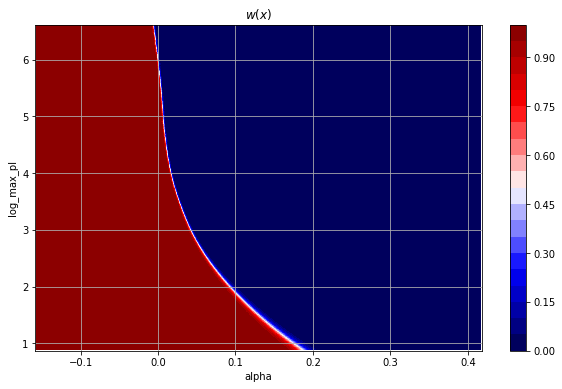

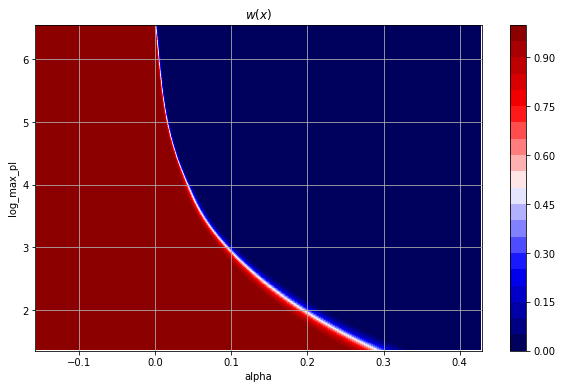

In [57]:
plot_field(w_la.w_model_np(), w_la.dataset(), r'$w(x)$', save='result_la.pdf')
plot_field(w_la3.w_model_np(), w_la3.dataset(), r'$w(x)$', save='result_la3.pdf')

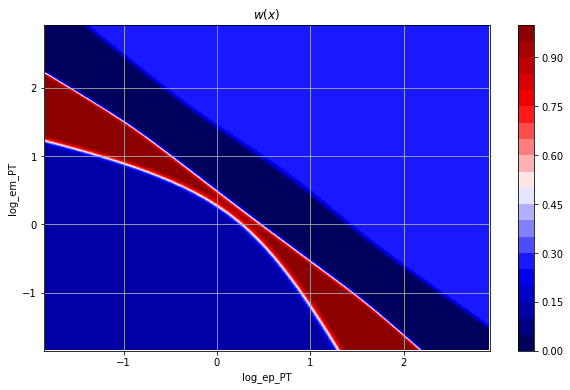

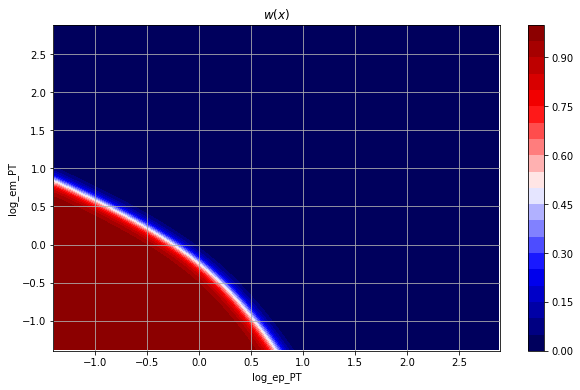

In [58]:
plot_field(w_ptpt.w_model_np(), w_ptpt.dataset(), r'$w(x)$')
plot_field(w_ptpt3.w_model_np(), w_ptpt3.dataset(), r'$w(x)$')

In [59]:
df = df.iloc[0:8,0:1]
df

Total
B⁺→K⁺ee          970116
B⁺→K⁺J/ψ(→ee)    960234
B⁺→K⁺ψ(2S)(→ee)  986271
D⁺→π⁺φ(→ee)      830027

In [60]:
for name, w in [("w", w_la), ("w3", w_la3), ("wpt", w_ptpt), ("wpt3", w_ptpt3)]:
    ds = w.dataset()
    df[name] = None
    for label, idx in ds.mapping.items():
        d = ds.X[ds.Y==label]
        wd = w.w_model_np()(d)
        df.loc[df.index[idx],name] = np.mean(wd)
        df.loc[df.index[idx],"1-"+name] = 1-np.mean(wd)
df

Total         w       1-w        w3      1-w3       wpt  \
B⁺→K⁺ee          970116  0.023143  0.976857  0.112448  0.887552  0.193139   
B⁺→K⁺J/ψ(→ee)    960234  0.004342  0.995658  0.007569  0.992431  0.160276   
B⁺→K⁺ψ(2S)(→ee)  986271  0.004341  0.995659  0.007582  0.992418  0.160336   
D⁺→π⁺φ(→ee)      830027   0.00437  0.995630      None       NaN   0.16032   

                    1-wpt      wpt3    1-wpt3  
B⁺→K⁺ee          0.806861  0.049445  0.950555  
B⁺→K⁺J/ψ(→ee)    0.839724  0.023722  0.976278  
B⁺→K⁺ψ(2S)(→ee)  0.839664  0.023665  0.976335  
D⁺→π⁺φ(→ee)      0.839680      None       NaN

In [61]:
def r_K(a): return 1/a[0]
def r_Jpsi(a): return 1/a[1]
def r_psi2S(a): return 1/a[2]
def R_K(a): return r_K(a)/r_Jpsi(a)
def R_psi2S(a): return r_psi2S(a)/r_Jpsi(a)

def double_ratio(a): return R_K(a)
def double_ratio_psi2S(a): return R_psi2S(a)

In [62]:
double_ratio(df["1-w"]), double_ratio_psi2S(df["1-w"])

(1.0192469493115983, 0.9999988957805109)

In [63]:
1/double_ratio(df["1-w"]), 1/double_ratio_psi2S(df["1-w"])

(0.9811165004471215, 1.0000011042207084)

In [64]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.18760826944342948, 1.0002532776716049)

In [65]:
1/double_ratio(df["w"]), 1/double_ratio_psi2S(df["w"])

(5.330255446450538, 0.9997467864617305)

### Conditional plots

In [66]:
def plot_e(w_obj, feature, bins):
    ds = w_obj.dataset()
    ds_features = ds.features
    Xf, Yf, mf = make_dataset(ds_features, range(4))
    Xc, Yc, mc = make_dataset([feature], range(4))
    fn = w_obj.w_model_np()
    bins_q2 = np.linspace(0,14e6,101)
    for label, idx in ds.mapping.items():
        d = Xf[Yf==label]
        wd = 1-fn(d)
        q2d = Xc[Yc==label,0]
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        plt.step(bins[:-1], hd, where='post', label=df_index[idx])
    plt.title("e(%s) for %s" % (feature, ds_features))
    plt.legend()
    plt.grid()
    plt.show()

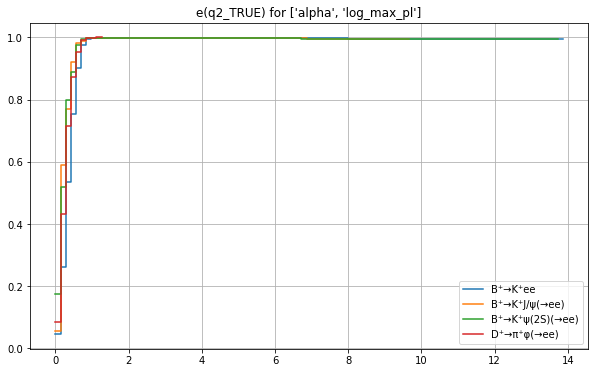

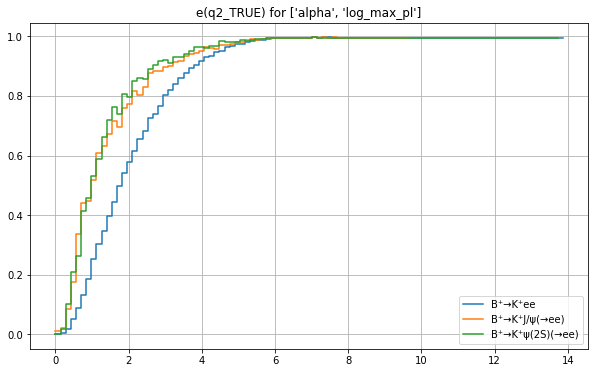

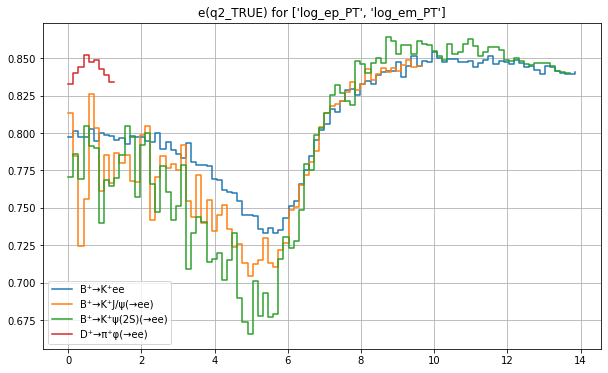

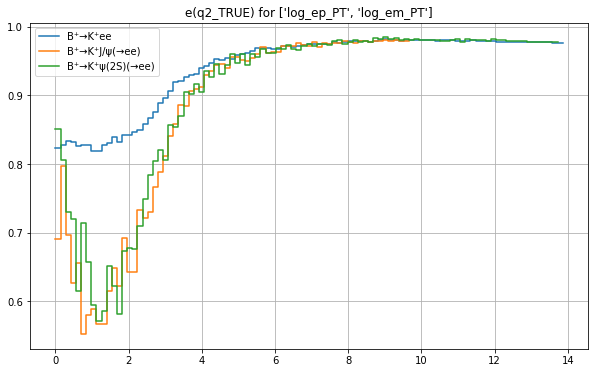

In [67]:
plot_e(w_la, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_la3, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_ptpt, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_ptpt3, "q2_TRUE", bins=np.linspace(0,14,101))

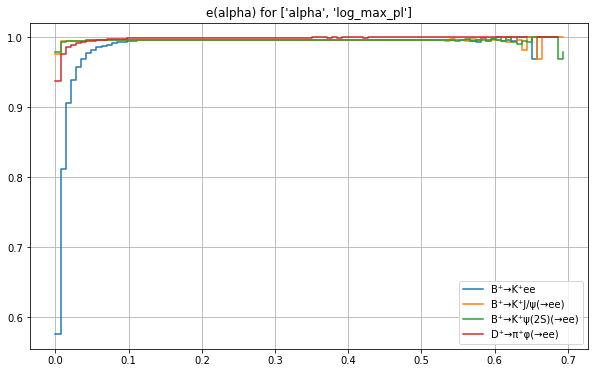

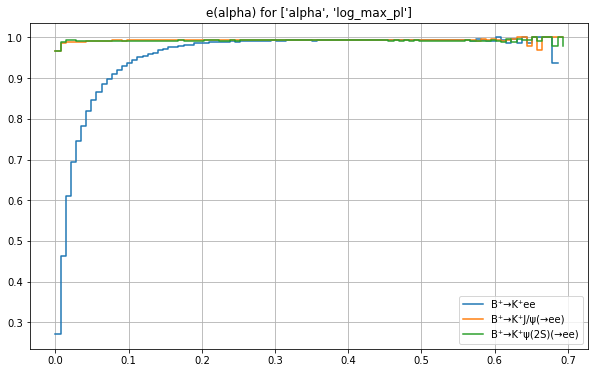

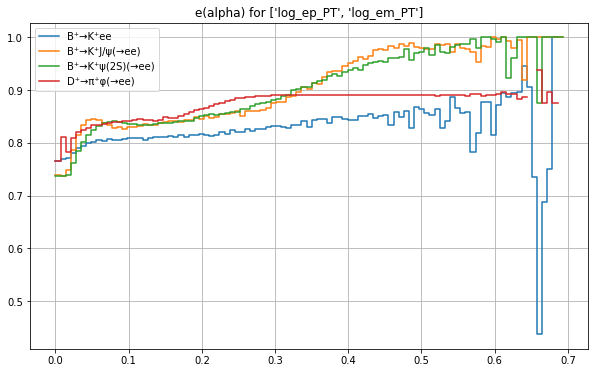

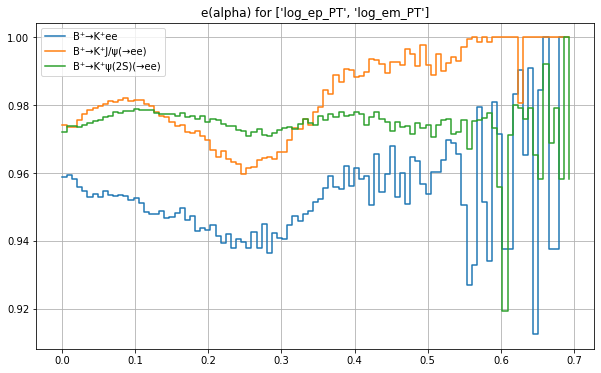

In [68]:
plot_e(w_la, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_la3, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_ptpt, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_ptpt3, "alpha", bins=np.linspace(0,0.7,101))

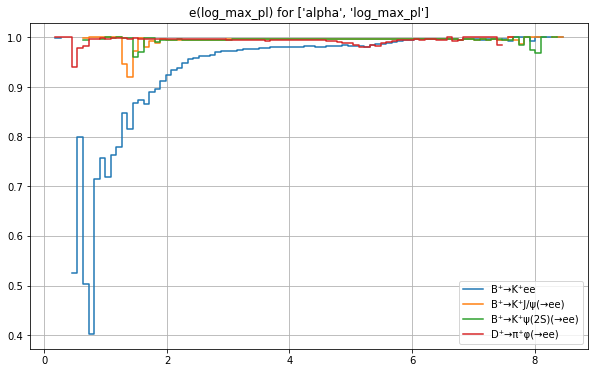

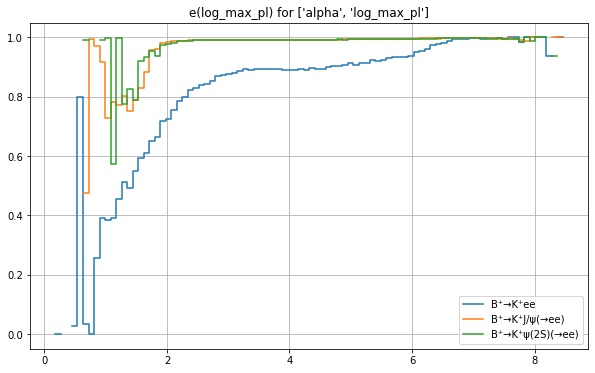

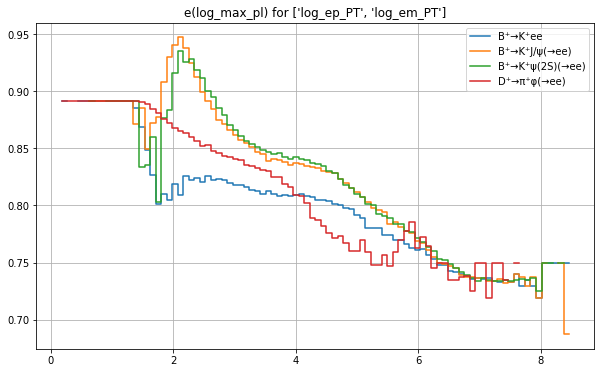

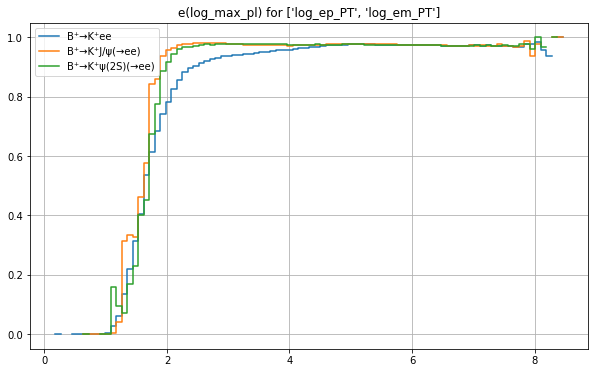

In [69]:
plot_e(w_la, "log_max_pl", bins=np.linspace(0,9,101))
plot_e(w_la3, "log_max_pl", bins=np.linspace(0,9,101))
plot_e(w_ptpt, "log_max_pl", bins=np.linspace(0,9,101))
plot_e(w_ptpt3, "log_max_pl", bins=np.linspace(0,9,101))

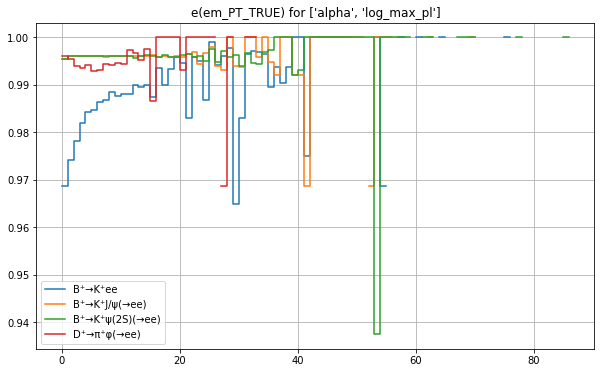

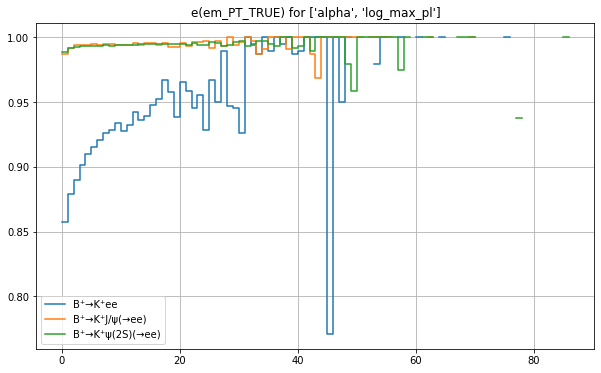

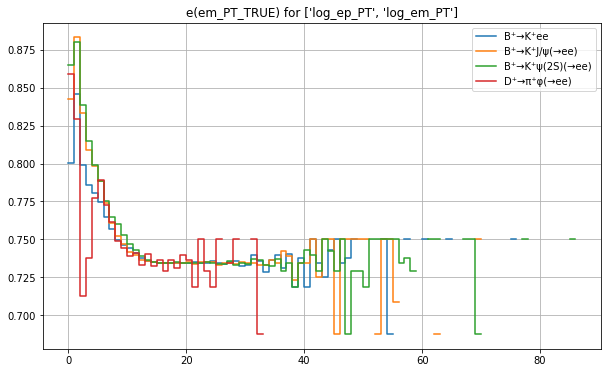

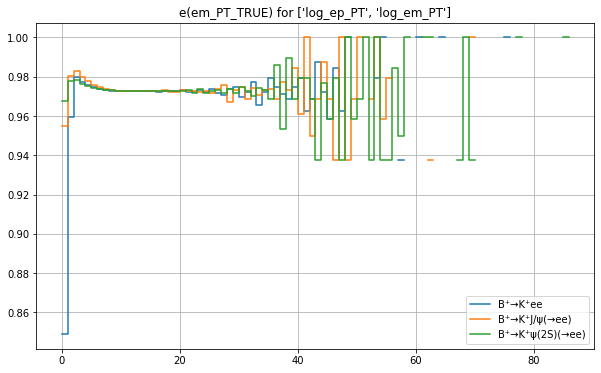

In [70]:
plot_e(w_la, "em_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_la3, "em_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt, "em_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt3, "em_PT_TRUE", bins=np.linspace(0,100,101))

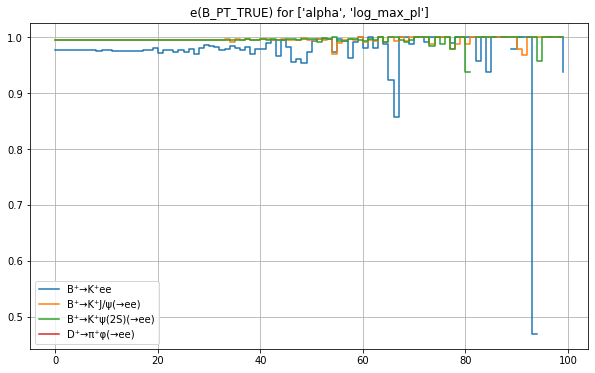

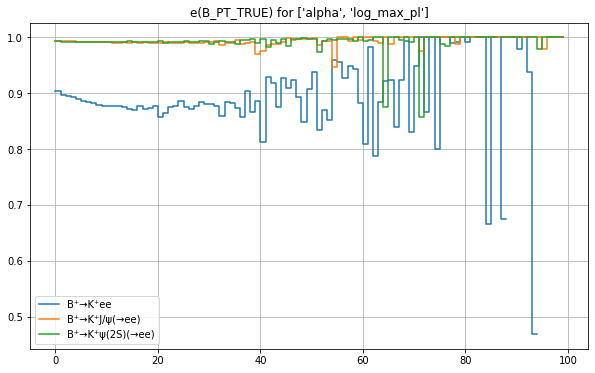

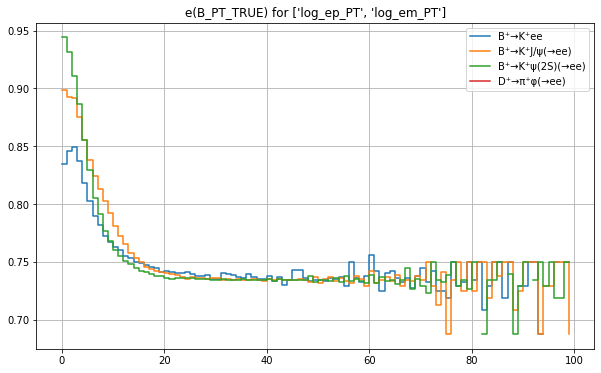

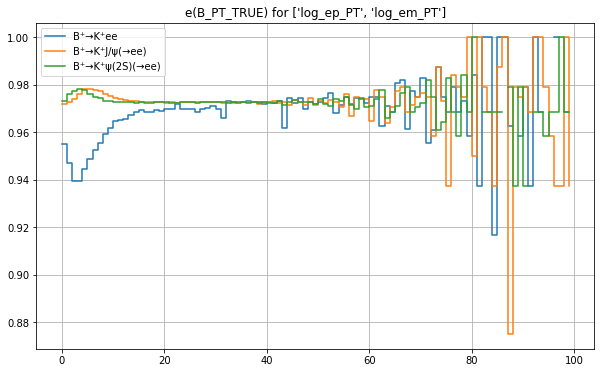

In [71]:
plot_e(w_la, "B_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_la3, "B_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt, "B_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt3, "B_PT_TRUE", bins=np.linspace(0,100,101))

### Single feature

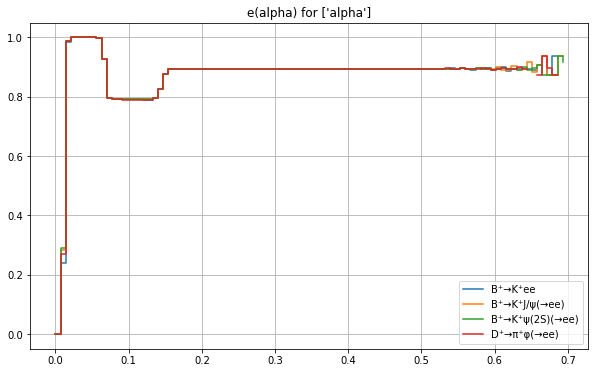

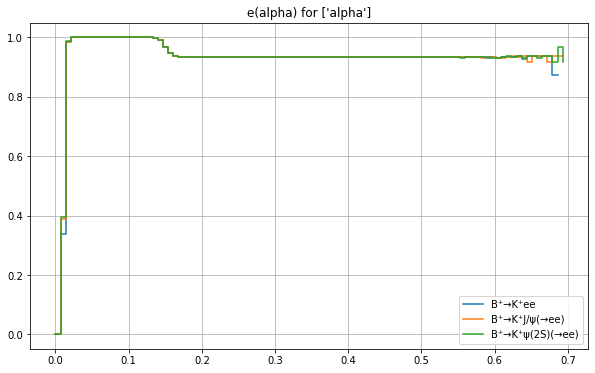

In [72]:
plot_e(w_a4, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_a3, "alpha", bins=np.linspace(0,0.7,101))

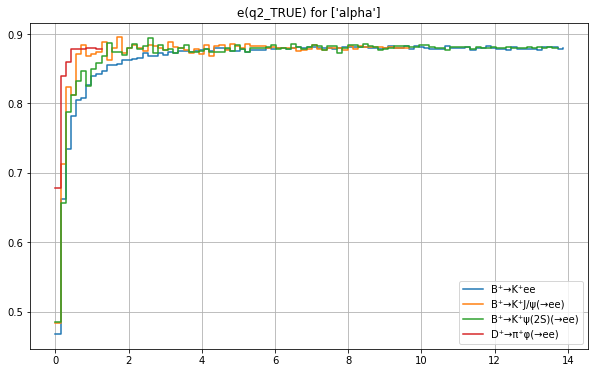

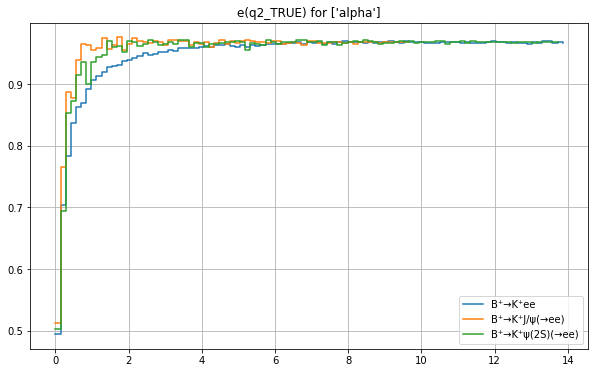

In [73]:
plot_e(w_a4, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_a3, "q2_TRUE", bins=np.linspace(0,14,101))